# Analyze predicted escape from the 3K antibodies

## Import `Python` modules

In [1]:
import os
import glob
from collections import defaultdict
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(font_scale=1.0, style='ticks', palette='colorblind')

## Read in data that predicts how much each virus has escaped each antibody

Read in site-wise escape scores

In [2]:
# Read in site-level escape scores
escape_calc_resultsdir = 'data/ncov_escape_scores/'
site_escape_df = pd.read_csv(os.path.join(escape_calc_resultsdir, 'escape.csv'))

# Read in dataframe specifying which studies the
# antibodies came from
ab_source_df = pd.read_csv(os.path.join(escape_calc_resultsdir, 'antibody_sources.csv'))

# Make a list of antibodies from the imprinted_2022 study
# to analyze below
imprinted_2022_abs = ab_source_df[
    ab_source_df['study'] == 'imprinted_2022'
]['antibody'].unique()

Read in predicted escape scores

In [3]:
f = 'data/ncov_escape_scores/all_predictions.csv'
escape_df = pd.read_csv(f)
escape_df.rename(columns={'group':'ab_group'}, inplace=True)
escape_df['escape_score'].clip(upper=1.0, inplace=True)
escape_df.head()

,strain,aa_substitutions,escape_score,antibody,ab_group,date,Nextstrain_clade,time
0,ON641975.1,NaN,0.000000,BD55-6049,E3,2022-01-08,?,2.038356
1,ON641975.1,G446S N501Y,0.020197,BD56-965,B,2022-01-08,?,2.038356
2,ON641975.1,NaN,0.000000,XGv-318,F1,2022-01-08,?,2.038356
3,ON641975.1,NaN,0.000000,BD55-5687,E3,2022-01-08,?,2.038356
4,ON641975.1,E484A,0.005702,XGv-214,E2.1,2022-01-08,?,2.038356


First, we're interested in quantifying escape of viruses from antibodies in the last 6 months of the pandemic. To do this, we'll first get data for viruses from the past 6 months.

In [4]:
# Get data for all viruses after timepoint 2.5
recent_data = escape_df[escape_df['time'] > 2.5].copy()

Next, we will group the data by the antibody group. For each group, we will compute the average escape of all viruses from antibodies in that group.

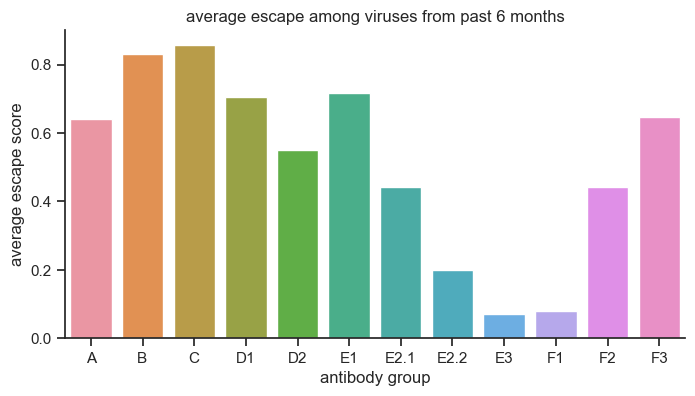

In [5]:
avg_escape_data = recent_data.groupby('ab_group').mean(numeric_only=True)
avg_escape_data.reset_index(inplace=True)
plt.figure(figsize=[8,4])
sns.barplot(x='ab_group', y='escape_score', data=avg_escape_data)
plt.title('average escape among viruses from past 6 months')
plt.xlabel('antibody group')
plt.ylabel('average escape score')
sns.despine()
plt.show()

**Observations**
* Many of the antibody groups have high average escape scores, some have mediocre escape scores
* What could explain this pattern? One idea is that the epitopes with low escape scores are non-neutralizing.

Next, for each antibody group, we'll plot escape over time. To do this, we'll need to implement our sliding-window approach from before. First, we will define where our windows are.

In [6]:
# Define parameters for windows
start_time = 0
end_time = 3.3
window_width = 0.2
window_step_size = 0.1

# To start, we set the left side of our window at a value
# of zero
left_side_of_window = 0

# We're going to define all windows one at a time
# based on the step size and width
list_of_left_sides_of_windows = []
while (left_side_of_window + window_step_size) <= end_time:
    
    # Append the window value to the list
    list_of_left_sides_of_windows.append(left_side_of_window)
    #print(left_side_of_window, left_side_of_window+window_width)

    # Slide the window to the right by one step
    left_side_of_window = left_side_of_window + window_step_size

Plot the number of viruses in each window

n windows: 32
Median n viruses per window: 63.0


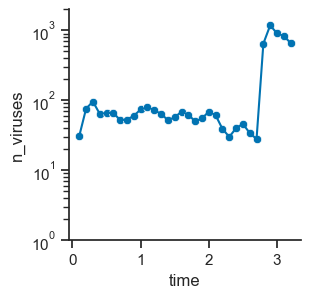

In [7]:
# Iterate over each window and record data
virus_counts_dict = defaultdict(list)
for left_side_of_window in list_of_left_sides_of_windows:
    right_side_of_window = left_side_of_window + window_width
    center_of_window = (left_side_of_window + right_side_of_window) / 2
    
    # Get data for viruses within a given window
    data = escape_df[
        (escape_df['time'].between(left_side_of_window, right_side_of_window))
    ][['strain', 'time']].drop_duplicates()
    virus_counts_dict['time'].append(center_of_window)
    virus_counts_dict['n_viruses'].append(len(data))

virus_counts_df = pd.DataFrame(virus_counts_dict)
print('n windows:', len(virus_counts_df))
print('Median n viruses per window:', virus_counts_df['n_viruses'].median())

# Plot data
plt.figure(figsize=[3,3])
sns.lineplot(x='time', y='n_viruses', data=virus_counts_df)
sns.scatterplot(x='time', y='n_viruses', data=virus_counts_df)
plt.yscale('log')
plt.ylim([1,2000])
sns.despine()
plt.show()

Compute clade frequencies in each window

In [8]:
# Initiate a series with zero counts for each clade
zeros_dict = {
    clade : 0
    for clade in escape_df['Nextstrain_clade'].unique()
}
zeros_series = pd.Series(zeros_dict)

# Iterate over each window and record data
list_of_series = []
for left_side_of_window in list_of_left_sides_of_windows:
    right_side_of_window = left_side_of_window + window_width
    
    # Get data for viruses within a given window
    data = escape_df[
        (escape_df['time'].between(left_side_of_window, right_side_of_window))
    ].copy()
    data.drop_duplicates(subset='strain', inplace=True)
    clade_counts = (data['Nextstrain_clade'].value_counts() + zeros_series).fillna(0)
    clade_freqs = clade_counts / clade_counts.sum()
    list_of_series.append(clade_freqs)

clade_freqs_df = pd.DataFrame(list_of_series)
clade_freqs_df['time'] = list_of_left_sides_of_windows
clade_freqs_df['time'] += window_width/2
value_vars = [col for col in clade_freqs_df if col != 'time']
clade_freqs_df = clade_freqs_df.melt(
    id_vars='time', value_vars=value_vars,
    var_name='clade', value_name='freq'
)
clade_freqs_df.head()

,time,clade,freq
0,0.1,19A,0.548387
1,0.2,19A,0.250000
2,0.3,19A,0.145833
3,0.4,19A,0.078125
4,0.5,19A,0.000000


Next, for each antibody, compute the average escape across all viruses in a window.

In [9]:
# Make a dictionary for keeping track of averages in each window
window_data = defaultdict(list)

# Iterate over each window and record data
dfs = []
for left_side_of_window in list_of_left_sides_of_windows:
    right_side_of_window = left_side_of_window + window_width
    center_of_window = (left_side_of_window + right_side_of_window) / 2
    
    # Get data for viruses within a given window
    data = escape_df[
        (escape_df['time'].between(left_side_of_window, right_side_of_window))
    ].copy()
    groupby_cols = [
        'antibody',
        'ab_group'
    ]
    data = data.groupby(groupby_cols).mean(numeric_only=True).reset_index()
    data['time'] = center_of_window
    dfs.append(data)

window_data = pd.concat(dfs)
window_data.head()

,antibody,ab_group,escape_score,time
0,1-57,D1,0.000000,0.1
1,2-15,C,0.000000,0.1
2,7D6,C,0.000000,0.1
3,ADG-2,F3,0.029848,0.1
4,B38,A,0.000000,0.1


Plot the average escape over time for each group

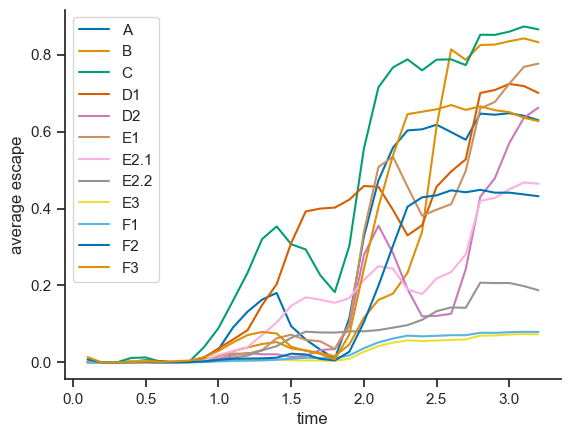

In [10]:
data = window_data.groupby(['ab_group', 'time']).mean(numeric_only=True).reset_index()
sns.lineplot(
    x='time', y='escape_score', data=data,
    hue='ab_group', palette='colorblind'
)
plt.legend()
plt.xlabel('time')
plt.ylabel('average escape')
sns.despine()
plt.show()

Make separate subplots for each group

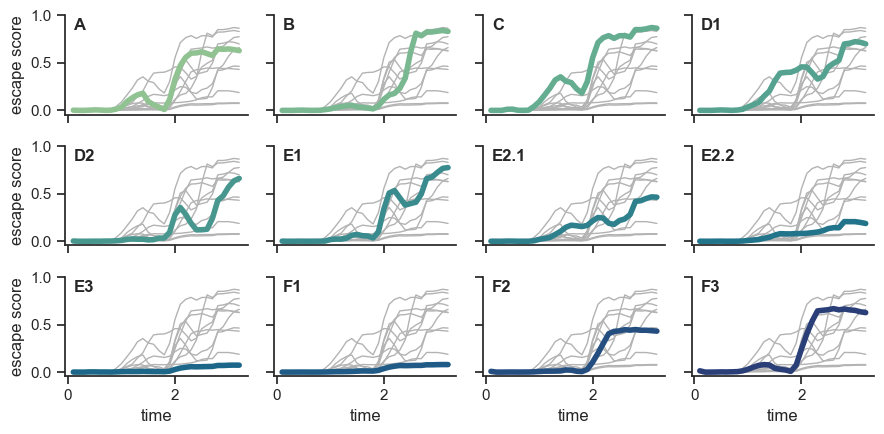

In [11]:
# Plot each antibody group's time series in its own facet
groupby_col = 'antibody'
data = window_data.groupby(['ab_group', 'time']).mean(numeric_only=True).reset_index()
g = sns.relplot(
    data=data,
    x="time", y="escape_score", col="ab_group", hue="ab_group",
    kind="line", palette="crest",
    linewidth=4, zorder=5,
    col_wrap=4, height=1.5, aspect=1.5, legend=False,
)

# Then plot other antibodies from group or other antibody
# groups in the background
groupby_cols = [
    #'antibody',
    'ab_group',
    'time'
]

for ab_group, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.05, .85, ab_group, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    if groupby_cols[0] == 'antibody':
        data = window_data[
            window_data['ab_group'] == ab_group
        ].groupby(groupby_cols).mean(numeric_only=True).reset_index()
    else:
        data = window_data.groupby(groupby_cols).mean(numeric_only=True).reset_index()
    sns.lineplot(
        data=data, x="time", y="escape_score", units=groupby_cols[0],
        estimator=None, color=".7", linewidth=1, ax=ax,
    )
    ax.set(yticks=[0,0.5,1])

# Reduce the frequency of the x axis ticks
#ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("time", "escape score")
g.tight_layout()
plt.show()

Cluster antibodies using K-means clustering

In [12]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import numpy as np

In [13]:
pivot_df = window_data.pivot(index=['antibody', 'ab_group'], columns= 'time', values='escape_score')#.fillna(0)

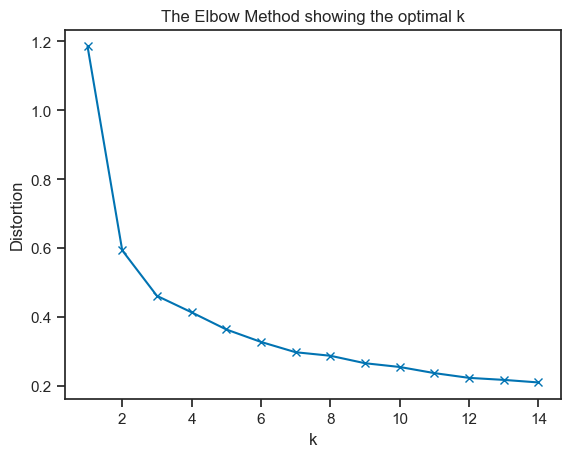

In [14]:
# Compute optimal number of clusters using Elbow method
distortions = []
K = range(1,15) # This range can be adjusted depending on use case
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0, n_init=100, max_iter=10000)
    kmeanModel.fit(pivot_df)
    distortions.append(sum(np.min(cdist(pivot_df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / pivot_df.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [15]:
# Pick the optimal number of clusters by examining the elbow plot
n_clusters = 10 # change this based on your elbow plot result

#NOTE: we chose a large K value due to the large dataset we used

# Perform k-means clustering
pivot_df = window_data.pivot(index=['antibody', 'ab_group'], columns= 'time', values='escape_score')#.fillna(0)
pivot_df.clip(upper=0.8, inplace=True)
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=1000, max_iter=10000, tol=1e-6).fit(pivot_df)

# Add the cluster labels back into the pivot dataframe
pivot_df['cluster'] = kmeans.labels_

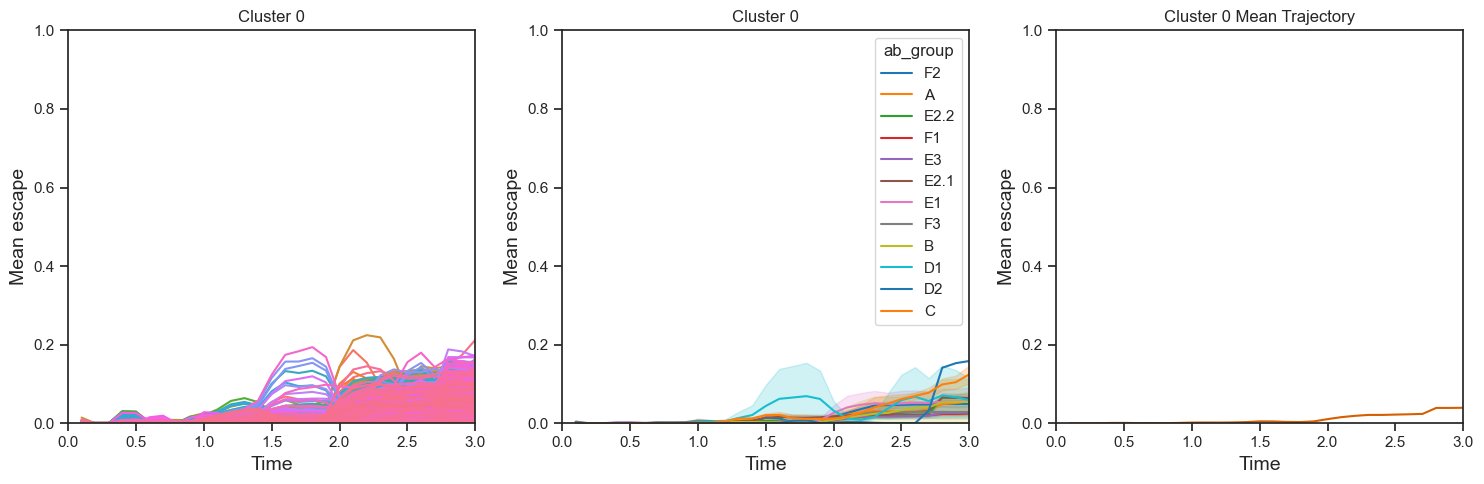

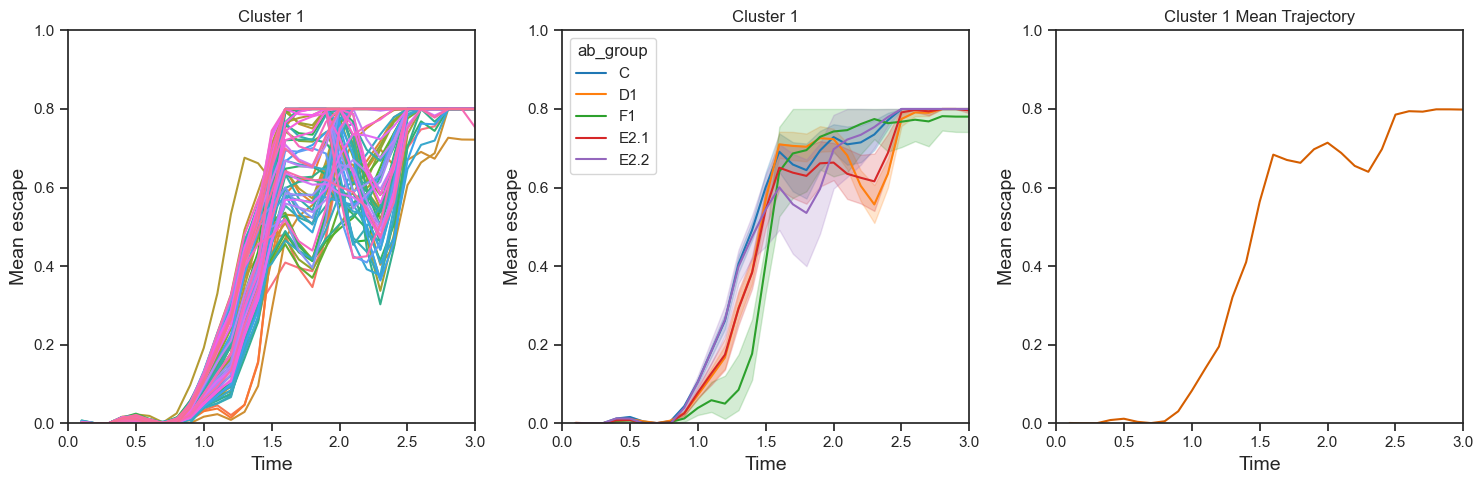

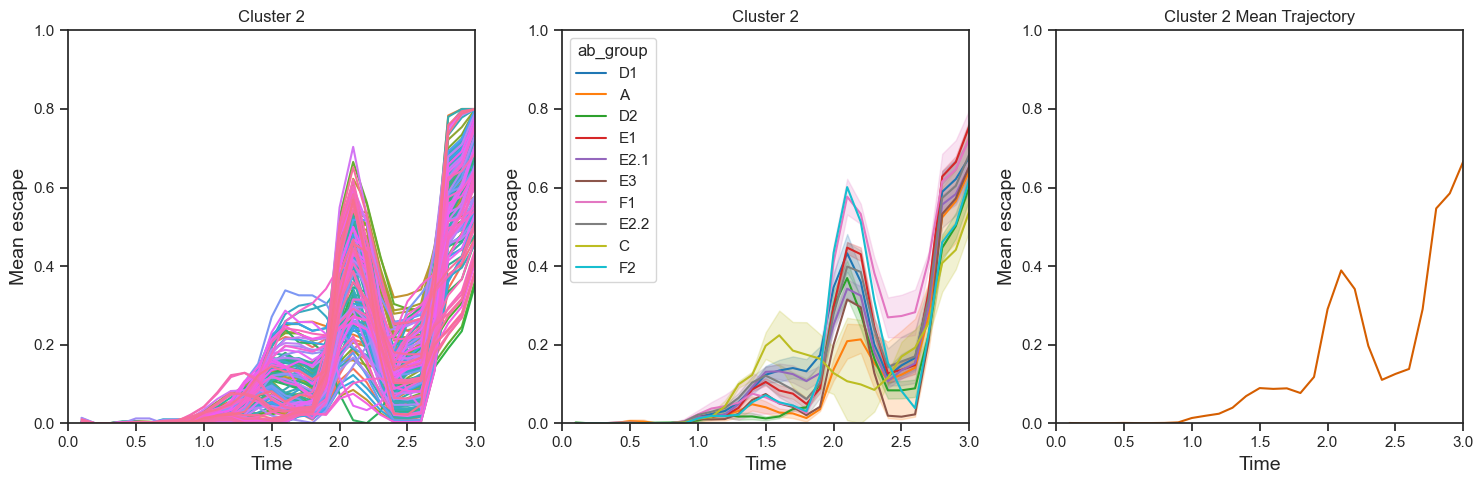

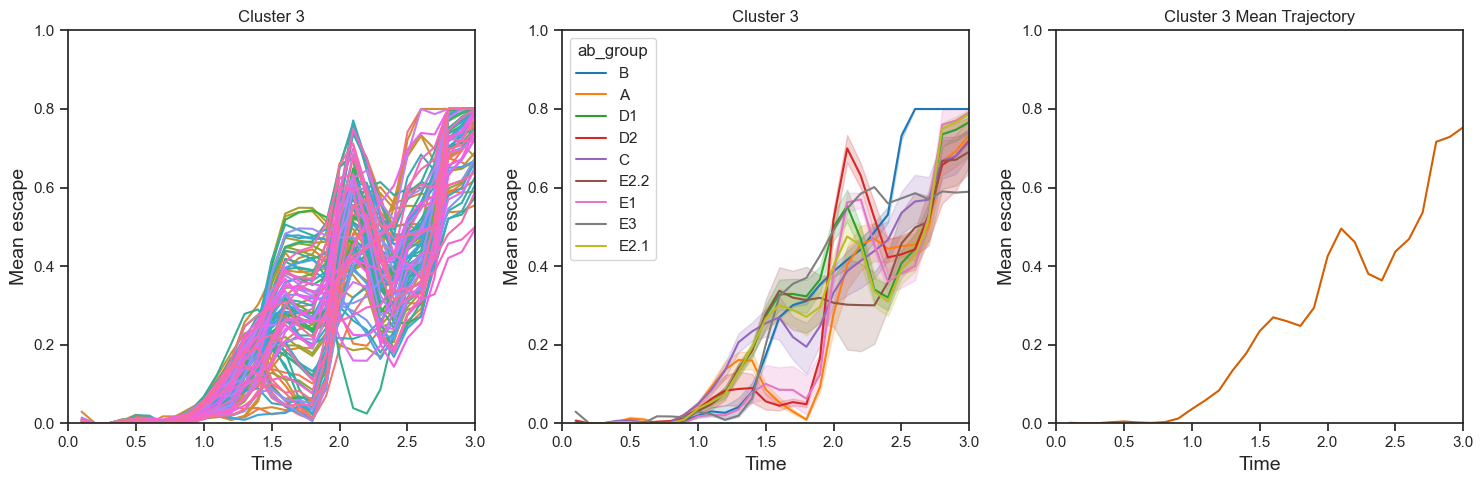

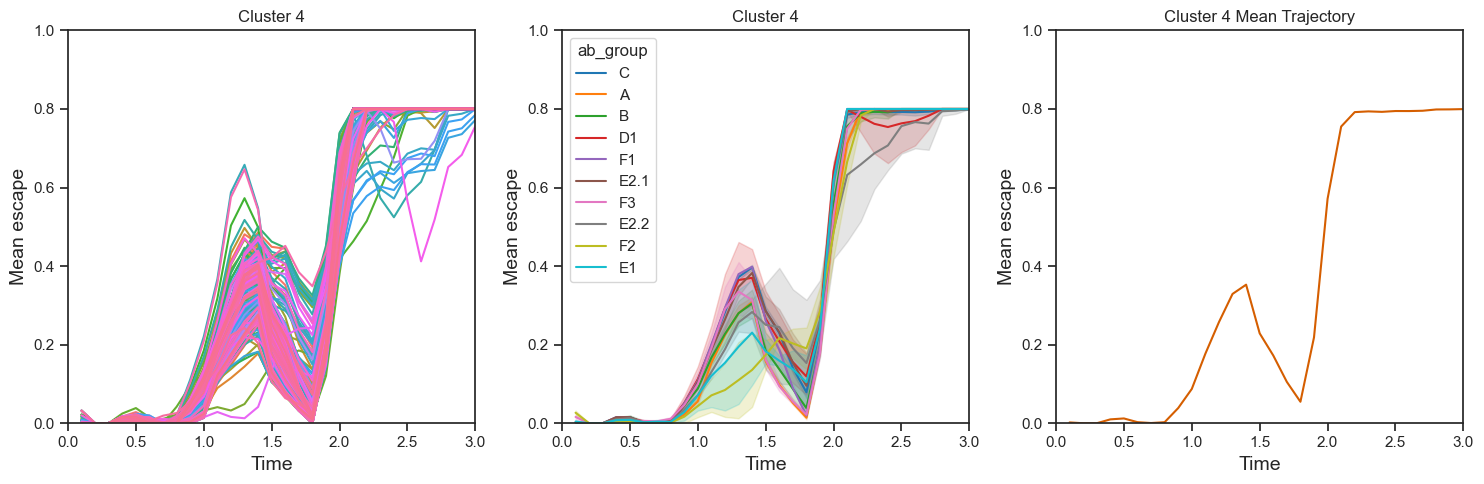

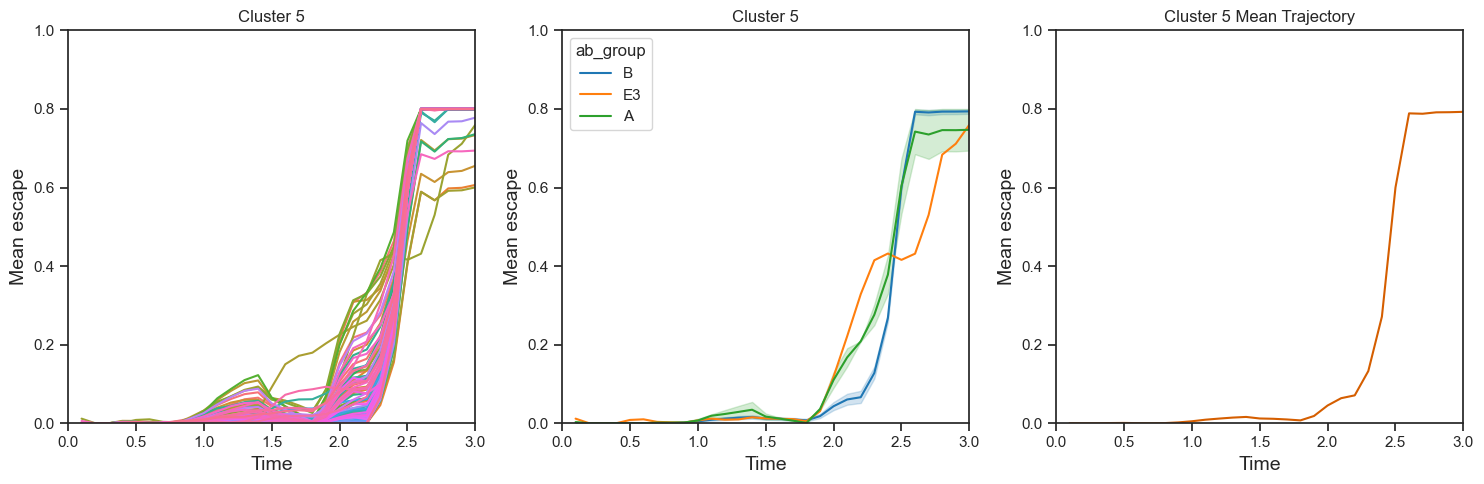

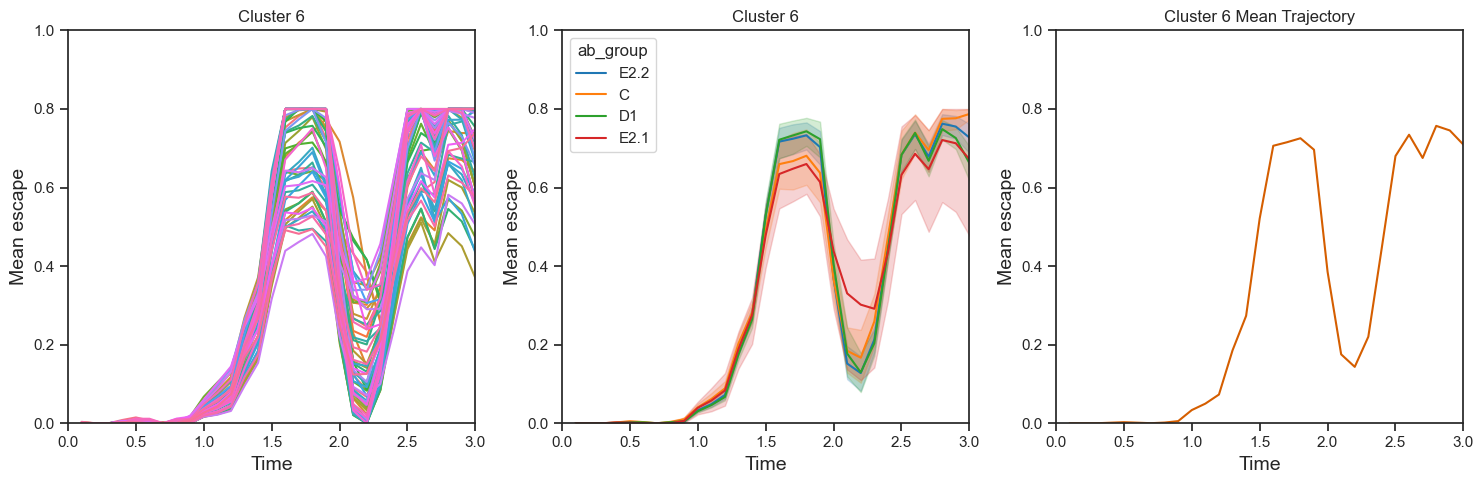

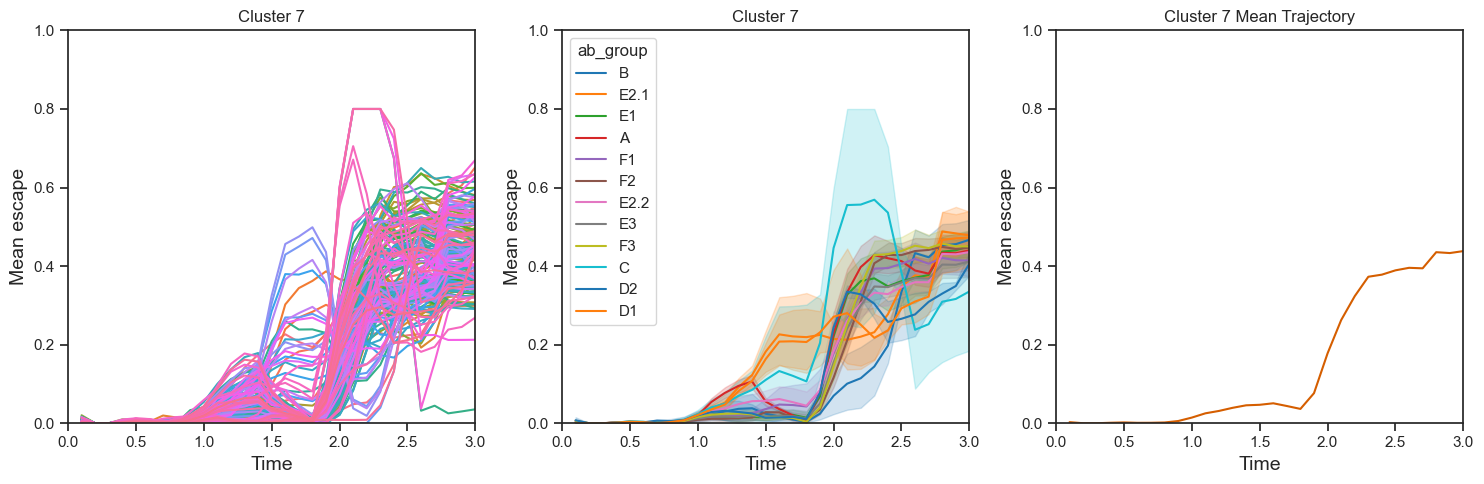

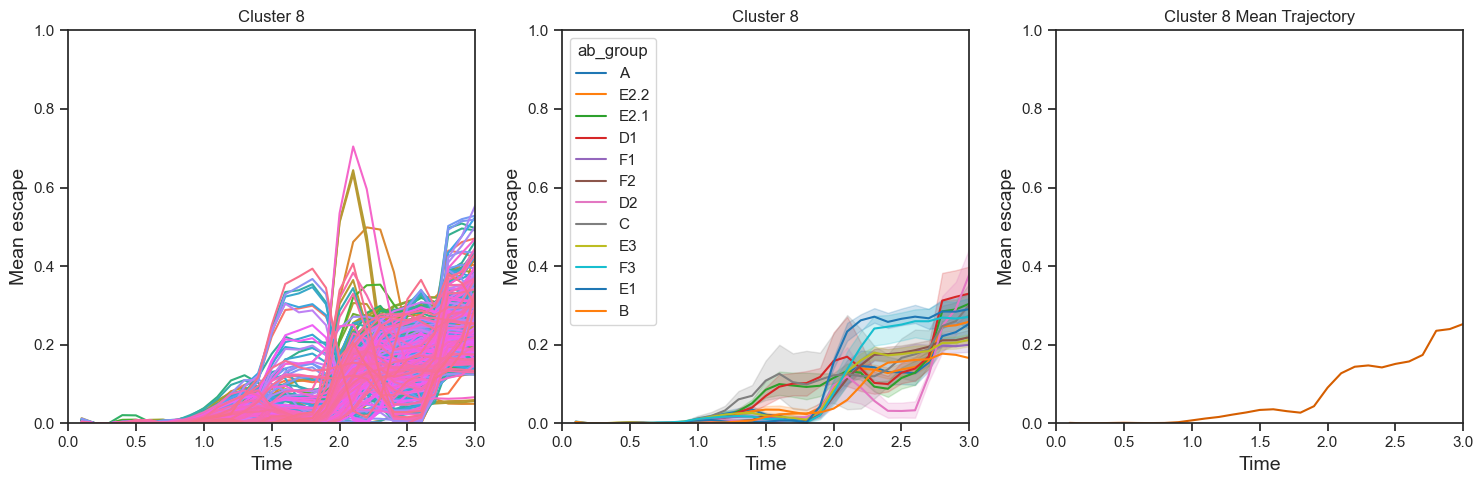

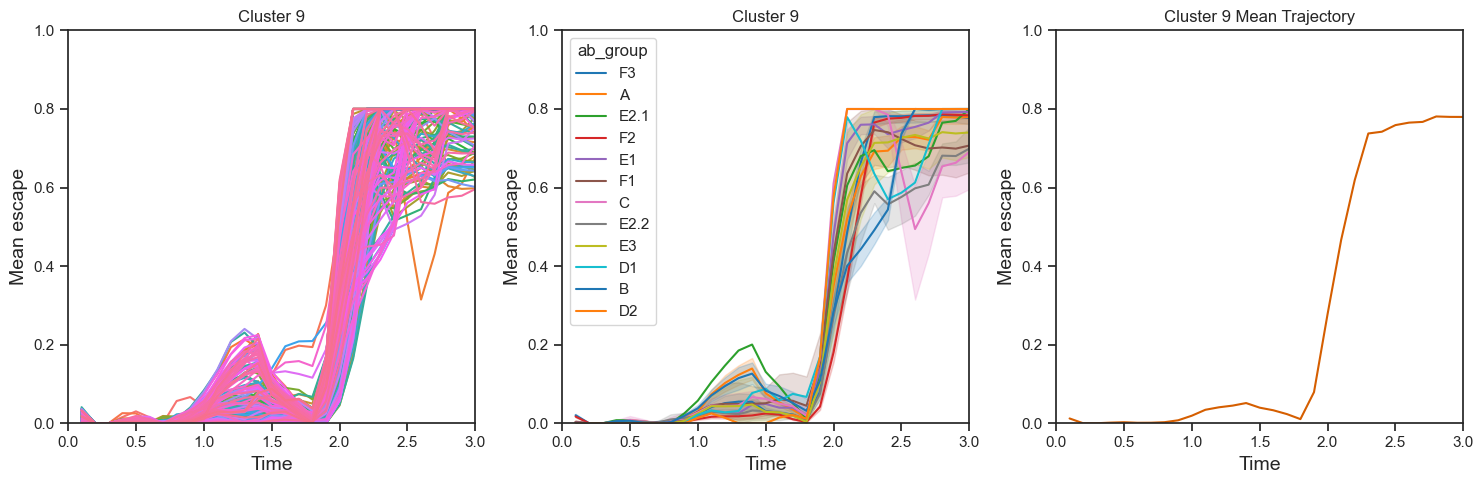

In [16]:
# For each cluster, plot all the antibodies in the cluster
for cluster in range(n_clusters):
    cluster_df = pivot_df[
        (pivot_df['cluster'] == cluster)
    ].drop(columns='cluster').reset_index()
    cluster_df = cluster_df.melt(id_vars=['ab_group', 'antibody'])
    cluster_df.time = cluster_df.time.astype(float)
    
    # Start subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5)) 
    
    # Normal plot with all antibodies in the cluster
    sns.lineplot(data=cluster_df, x='time', y='value', hue='antibody', ax=axs[0],legend=False)
    axs[0].set_title(f'Cluster {cluster}')
    axs[0].set_xlabel('Time', fontsize=14) 
    axs[0].set_ylabel('Mean escape', fontsize=14)    
    
    # Plot classified by antibody group
    sns.lineplot(data=cluster_df, x='time', y='value', hue='ab_group', palette='tab10', ax=axs[1])
    axs[1].set_title(f'Cluster {cluster}')
    axs[1].set_xlabel('Time', fontsize=14) 
    axs[1].set_ylabel('Mean escape', fontsize=14) 

    # Plot displaying mean trajectory
    sns.lineplot(data=cluster_df, x='time', y='value', errorbar=None, estimator=np.mean, color='r', ax=axs[2])
    axs[2].set_title(f'Cluster {cluster} Mean Trajectory')
    axs[2].set_xlabel('Time', fontsize=14) 
    axs[2].set_ylabel('Mean escape', fontsize=14)
    
    # set x and y axis limits
    axs[0].set_xlim([0, 3]) 
    axs[0].set_ylim([0, 1])
    axs[1].set_xlim([0, 3]) 
    axs[1].set_ylim([0, 1])
    axs[2].set_xlim([0, 3]) 
    axs[2].set_ylim([0, 1])
    
    #Show the plot
    plt.tight_layout()
    plt.show()

Sort the clusters based on when they are escaped and add a column giving the cluster ID for each antibody in the dataframe with escape over time

In [17]:
# Merge window data with cluster info
clustered_window_data = window_data.merge(
    pivot_df.reset_index()[['antibody', 'cluster']],
    on='antibody'
)

# Renumber clusters according to the cumulative sum
# of escape scores over time
data = clustered_window_data.groupby(['cluster', 'time']).mean(numeric_only=True).reset_index()
data['wtd_escape_score'] = 1/data['time'] * data['escape_score']
data_min_time = data[data['escape_score'] > 0.2].groupby('cluster').min().sort_values('escape_score', ascending=False)
data_max_time = data.groupby('cluster')[['time']].max()
data = data_min_time.merge(data_max_time, left_index=True, right_index=True, how='outer')
data['time'] = data[['time_x', 'time_y']].min(axis=1)
data.sort_values('time', ascending=True, inplace=True)
data.reset_index(inplace=True)
data.reset_index(names='sorted_cluster', inplace=True)
data['sorted_cluster'] += 1
clustered_window_data = clustered_window_data.merge(
    data[['cluster', 'sorted_cluster']], on='cluster'
)
clustered_window_data.head()

,antibody,ab_group,escape_score,time,cluster,sorted_cluster
0,1-57,D1,0.000000,0.1,2,5
1,1-57,D1,0.000000,0.2,2,5
2,1-57,D1,0.000000,0.3,2,5
3,1-57,D1,0.000199,0.4,2,5
4,1-57,D1,0.000659,0.5,2,5


Save the clustered window data to an output file

In [692]:
clustered_window_data.to_csv('results/escape_trajectories.csv', index=False)

Read in IC50s measured for a subset of viruses and merge with info on antibody source

In [512]:
# Read in IC50s from Cao et al.
ic50s_df = pd.read_csv(os.path.join(
    escape_calc_resultsdir, 'antibody_IC50s.csv'
))
ic50s_df['study'] = 'Cao et al.'

# Read in data from Wang et al.
cols = [
    'antibody', 'Spike', 'RBD', 'NTD',
    'av_D614G', 'av_Beta', 'av_Gamma', 'av_Delta', 'av_Omicron',
    'pv_D614G', 'pv_Alpha', 'pv_Beta', 'pv_Gamma', 'pv_Delta',
    'pv_Lamda', 'pv_Omicron',
    'BLI'
]
wang_ic50s_df = pd.read_excel(os.path.join(
    escape_calc_resultsdir, 'Wang_ic50_values.xlsx'
), skiprows=3, names=cols)
wang_ic50s_df = wang_ic50s_df.replace('>50', '50').replace('>10', 10).replace('NS', np.nan).replace('-', np.nan)
wang_ic50s_df.dropna(subset='antibody', inplace=True)
wang_ic50s_df['antibody'] = wang_ic50s_df['antibody'].apply(
    lambda x: x.replace('*', '').replace('XGv', 'XGv-')
)
wang_ic50s_df = wang_ic50s_df[
    ~wang_ic50s_df['antibody'].str.contains('data referenced')
]

dfs = [ic50s_df]
for virus_type in ['av', 'pv']:
    vt_cols = [col for col in wang_ic50s_df if virus_type in col]
    vt_ic50s_df = wang_ic50s_df[['antibody']+vt_cols].copy()
    vt_ic50s_df.rename(columns={
        col : col.replace(f'{virus_type}_', '')
        for col in vt_ic50s_df
    }, inplace=True)
    value_vars = [col for col in vt_ic50s_df if col != 'antibody']
    vt_ic50s_df = vt_ic50s_df.melt(
        id_vars='antibody', value_vars=value_vars,
        var_name='virus', value_name='IC50'
    )
    vt_ic50s_df['IC50'] = vt_ic50s_df['IC50'].astype(float)
    vt_ic50s_df['study'] = f'Wang et al. {virus_type}'
    vt_ic50s_df['virus'].replace({
        'Omicron':'BA.1',
        'Lamda':'Lambda',
    }, inplace=True)
    dfs.append(vt_ic50s_df)
    
ic50s_df = pd.concat(dfs)
ic50s_df['log_IC50'] = ic50s_df['IC50'].apply(lambda x: np.log10(x))

# Merge with data on antibody source
data = ab_source_df[
    ab_source_df['study'] == 'imprinted_2022'
]
ic50s_df = ic50s_df.merge(data[['antibody', 'source']], on='antibody')

# Make a dataframe with IC50s against D614G
init_ic50s_df = ic50s_df[
    (ic50s_df['virus'] == 'D614G') &
    (ic50s_df['study'] == 'Cao et al.')
].copy()
init_ic50s_df['IC50_weight'] = init_ic50s_df['IC50'].apply(lambda x: -np.log10(x/10))

What is the correlation in IC50s between different experiments?

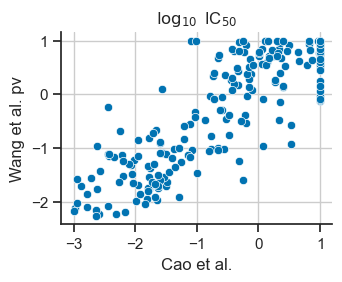

In [534]:
dfs = []
for strain in ['D614G', 'BA.1']:
    data = ic50s_df[
        ic50s_df['virus'] == strain
    ].pivot_table(
        index='antibody', columns='study', values='log_IC50'
    )
    dfs.append(data)
data = pd.concat(dfs)

plt.figure(figsize=[3.5,2.5])
sns.scatterplot(
    x='Cao et al.', y='Wang et al. pv', data=data
    #x='Wang et al. av', y='Wang et al. pv', data=data
)
#plt.axes(aspect='equal')
plt.title('$\log_{10}$ IC$_{50}$')
plt.grid()
sns.despine()
plt.show()

Compute a total escape score across all antibodies, weighted by the antibody's IC50 to the D614G strain, similar to the escape calculator.

['WT convalescents', 'WT vaccinees', 'BA.1 convalescents', 'BA.2 convalescents', 'BA.5 convalescents']


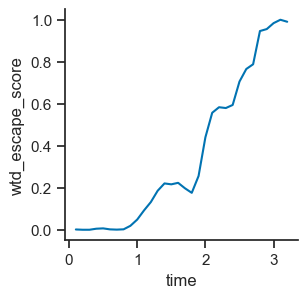

In [24]:
# Merge window escape data with data on IC50s
total_escape_window_data = clustered_window_data.merge(
    init_ic50s_df[['antibody', 'IC50', 'IC50_weight', 'source']],
    on='antibody'
)

# Compute weighted escape scores
total_escape_window_data['wtd_escape_score'] = \
    total_escape_window_data['escape_score'] * \
        total_escape_window_data['IC50_weight']

# Plot total escape over time
sources = [
    'WT convalescents', 'WT vaccinees',
    'BA.1 convalescents', 'BA.2 convalescents', 'BA.5 convalescents',
    #'SARS convalescents',
]
print(sources)
data = total_escape_window_data[
    total_escape_window_data['source'].isin(sources)
].copy()
data = data.groupby('time')[['wtd_escape_score']].sum().reset_index()
data['wtd_escape_score'] = data['wtd_escape_score'] / data['wtd_escape_score'].max()
plt.figure(figsize=[3,3])
sns.lineplot(x='time', y='wtd_escape_score', data=data)
sns.despine()
plt.show()

Plot escape over time

['WT convalescents', 'WT vaccinees', 'BA.1 convalescents', 'BA.2 convalescents', 'BA.5 convalescents']


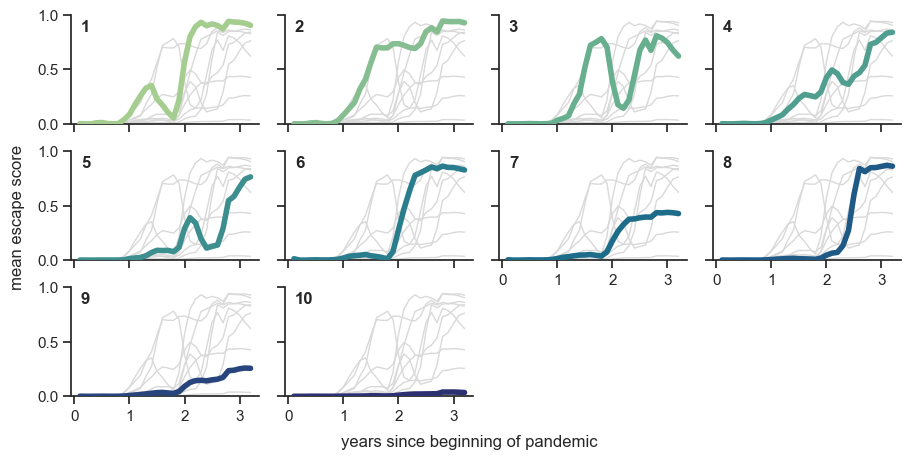

In [26]:
# Plot each antibody group's time series in its own facet
groupby_col = 'sorted_cluster' # 'ab_group' # 
data = clustered_window_data.groupby([groupby_col, 'time']).mean(numeric_only=True).reset_index()
g = sns.relplot(
    data=data,
    x="time", y="escape_score", col=groupby_col, hue=groupby_col,
    kind="line", palette="crest", # 'husl', 
    linewidth=4, zorder=5,
    col_wrap=4, height=1.5, aspect=1.5,
    legend=False,
)

# Then plot other antibodies from group or other antibody
# groups in the background
groupby_cols = [
    #'antibody',
    groupby_col,
    'time'
]
plot_total_escape = False
for group, ax in g.axes_dict.items():

    if not plot_total_escape:
        
        # Plot every year's time series in the background
        if groupby_cols[0] == 'antibody':
            data = clustered_window_data[
                clustered_window_data[groupby_col] == group
            ].groupby(groupby_cols).mean(numeric_only=True).reset_index()
        else:
            data = clustered_window_data.groupby(groupby_cols).mean(numeric_only=True).reset_index()
        sns.lineplot(
            data=data, x="time", y="escape_score", units=groupby_cols[0],
            estimator=None, color=".85", linewidth=1, ax=ax,
        )
    
    else:
        sources = [
            'WT convalescents', 'WT vaccinees',
            'BA.1 convalescents', 'BA.2 convalescents', 'BA.5 convalescents',
            #'SARS convalescents',
        ]
        data = total_escape_window_data[
            total_escape_window_data['source'].isin(sources)
        ].copy()
        data = data.groupby('time')[['wtd_escape_score']].sum().reset_index()
        data['wtd_escape_score'] = data['wtd_escape_score'] / data['wtd_escape_score'].max()
        sns.lineplot(
            x='time', y='wtd_escape_score', data=data, ax=ax,
            color='0.25', #linewidth=4,
        )
    
    ax.set(yticks=[0,0.5,1], ylim=[0,1])
    ax.text(.05, .85, group, transform=ax.transAxes, fontweight="bold")

# Tweak the supporting aspects of the plot
print(sources)
g.set_titles("")
g.set_axis_labels("", "")
g.fig.text(0.5, -0.01, 'years since beginning of pandemic', ha='center')
g.fig.text(-0.01, 0.5, 'mean escape score', va='center', rotation='vertical')
g.tight_layout(h_pad=0.01)
plt.show()

**Observations**
* Total weighted escape tends to increase over time, except when it dips down a bit at 1.75 years when Delta is prevalent. This dip is more pronounced when only analyzing antibodies from WT-infected/vaccinated people. There are a few parts where the total escape increases, then is flat for a short time, then increases again, almost in the shape of stairs. Possibly this is due to the fact that it takes time for new mutations to reach high frequency, which often happens via clade displacement?

Make a heatmap showing the number of antibodies from a given cluster from Cao et al. in a given cluster from K-means clustering.

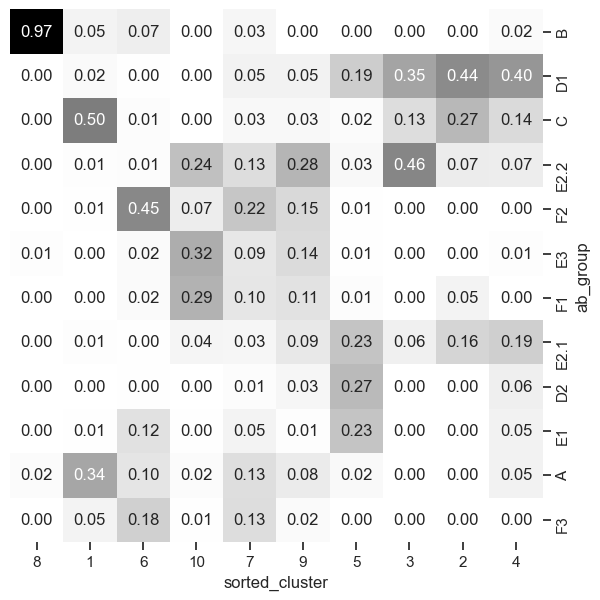

In [27]:
# Get a matrix with the number of antibodies in Cao clusters
# vs. K-means clusters
data = clustered_window_data[[
    'antibody', 'ab_group', 'sorted_cluster'
]].drop_duplicates()
#data[['ab_group', 'sorted_cluster']].value_counts()
data = data.groupby(['ab_group', 'sorted_cluster']).count().reset_index()
data = data.pivot_table(
    index='ab_group', columns='sorted_cluster',
    values='antibody'
).fillna(0).apply(lambda col: col/col.sum())

# Plot the data
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", ["white", "black"])
cg = sns.clustermap(
    data, annot=True, fmt=".2f",
    row_cluster=True, col_cluster=True, cmap=cmap,
    figsize=(7.5,7.5)
)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.cax.set_visible(False)

For each cluster, plot the number of antibodies and distribution of IC50 values.

['WT convalescents', 'WT vaccinees', 'BA.1 convalescents', 'BA.2 convalescents', 'BA.5 convalescents']


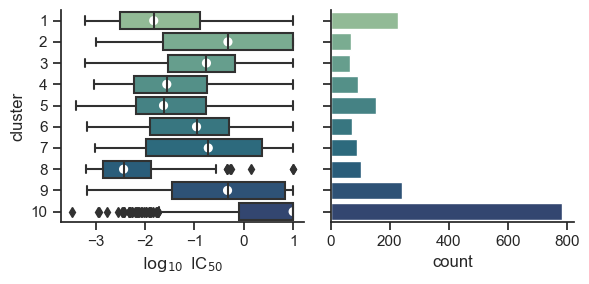

In [271]:
# Add a column to the IC50 df that gives the
# sorted cluster for each antibody
data = clustered_window_data[[
    'antibody', 'sorted_cluster', 'ab_group'
]].copy().drop_duplicates()
data = init_ic50s_df.merge(data, on='antibody')

# Plot data
sources = [
    'WT convalescents', 'WT vaccinees',
    'BA.1 convalescents', 'BA.2 convalescents', 'BA.5 convalescents',
    #'SARS convalescents',
]
print(sources)
data = data[data['source'].isin(sources)]

cluster_col = 'sorted_cluster' # 'ab_group'
data.sort_values(cluster_col, inplace=True)
(fig, axs) = plt.subplots(
    ncols=2, figsize=[6,3], sharey=True,
)
ic50_metric = 'log_IC50' # 'IC50_weight' # 
sns.boxplot(
    x=ic50_metric, y=cluster_col, data=data,
    orient='h', ax=axs[0], palette='crest'
)
sns.pointplot(
    x=ic50_metric, y=cluster_col, data=data,
    orient='h', ax=axs[0],
    join=False, estimator=np.median, errorbar=None,
    markers="o", scale=.75, color='w'
)
axs[0].set(ylabel='cluster', xlabel='$\log_{10}$ IC$_{50}$')
sns.countplot(
    y=cluster_col, data=data,
    ax=axs[1], palette='crest'
)
axs[1].set(ylabel='')
plt.tight_layout()
sns.despine()
plt.show()

**Observations**
* The order in which the antibodies were escaped does not really correlate with IC50 or number. This is the case even when subsetting to antibodies isolated from people infected/vaccinated with the "WT" strain

Make a list of mutations in each variant

In [187]:
from Bio import SeqIO
import sys
sys.path.append('data/')
import clusters
import scipy.stats

In [386]:
def get_mutations(refseq, seq):
    assert len(refseq) == len(seq)
    muts = [
        f'{ref_aa}{n}{aa}'
        for (n, (ref_aa, aa)) in enumerate(zip(refseq, seq), 1)
        if ref_aa != aa
    ]
    return muts

In [388]:
# Get list of sequences
seqs_dict = {}
for record in SeqIO.parse("data/ncov_escape_scores/aligned.gene.S.fasta", "fasta"):
    seqs_dict[record.id] = str(record.seq)
    
# For each sequence, make a list of mutations relative to the reference
ref_seq = seqs_dict['Wuhan-Hu-1/2019']
muts_dict = defaultdict(list)
for (seq_name, seq) in seqs_dict.items():
    muts_dict['virus'].append(seq_name)
    muts_dict['mutations'].append(
        set(get_mutations(ref_seq, seq)) # ' '.join(get_mutations(ref_seq, seq))
    )
    
muts_df = pd.DataFrame(muts_dict)

# Merge in clade info
clade_df = escape_df[['strain', 'Nextstrain_clade']].drop_duplicates().copy()
clade_df.rename(columns={'strain':'virus'}, inplace=True)
clade_df.head()
muts_df = muts_df.merge(clade_df, on='virus')
muts_df.head()

,virus,mutations,Nextstrain_clade
0,ON641975.1,"{H655Y, G446S, N679K, D796Y, S373P, A67V, S375...",?
1,FRA/IHUCOVID-046100_Nova1/2021,"{G261X, G446X, N440X, E324X, L441X, K444X, V52...",20A
2,ON395492.1,"{L7X, S46X, A93X, F194X, P57X, T22X, F4X, S371...",?
3,FRA/2205V210014/2022,"{H655Y, N679K, A27S, D796Y, E324X, S373P, S375...",21L (Omicron)
4,Japan/SZ-NIG-Y223306/2023,"{H655Y, N679K, A27S, D796Y, S373P, S375F, G142...",22B (Omicron)


In [528]:
# Get a dictionary giving the mutations in each clade
strain_muts_dict = clusters.clusters

# Map strains from IC50 experiments to clades from above dict
strain_and_clade_dict = {
    'Alpha' : 'Alpha',
    'Beta' : 'Beta',
    'Gamma' : 'Gamma',
    'Delta' : 'Delta',
    'Lambda' : '21GLambda',
    'BA.1' : '21K.Omicron',
    'BA.2' : '21L.Omicron',
    'BA.2.75' : '22D',
    'BA.5' : '22B',
    'BQ.1.1' : '22E',
    'XBB' : '22F'
}
strain_virus_dict = {
    'D614G' : ('Wuhan-Hu-1/2019', [])
}
muts_to_ignore = ['R493Q', 'Q493Q']
for (strain, clade) in strain_and_clade_dict.items():
    muts = [
        f"{entry['left']}{entry['pos']}{entry['right']}" for entry in
        strain_muts_dict[clade]['mutations']['nonsynonymous']
        if entry['gene'] == 'S'
    ]
    for mut in muts_to_ignore:
        if mut in muts:
            muts.remove(mut)
    if strain == 'BQ.1.1':
        muts.append('R346T')
    print(strain, muts)

    # Get the virus with the fewest differences
    muts_df['diffs'] = muts_df['mutations'].apply(
        lambda x: set.symmetric_difference(x, muts)
    )
    muts_df['ndiffs'] = muts_df['diffs'].apply(lambda x: len(x))
    muts_df.sort_values(['ndiffs', 'virus'], inplace=True)
    virus = muts_df['virus'].iloc[0]
    ndiffs = muts_df['ndiffs'].iloc[0]
    diffs = muts_df['diffs'].iloc[0]

    strain_virus_dict[strain] = (virus, muts)
    
    print(virus, ndiffs, diffs, '\n')

Alpha ['H69-', 'V70-', 'Y144-', 'N501Y', 'A570D', 'D614G', 'P681H', 'T716I', 'S982A', 'D1118H']
BHR/341841542/2021 0 set() 

Beta ['D80A', 'D215G', 'L241-', 'L242-', 'A243-', 'K417N', 'E484K', 'N501Y', 'D614G', 'A701V']
PHL/COVID58620/2021 1 {'A27S'} 

Gamma ['L18F', 'T20N', 'P26S', 'D138Y', 'R190S', 'K417T', 'E484K', 'N501Y', 'D614G', 'H655Y', 'T1027I', 'V1176F']
Argentina/UW21043062038/2021 0 set() 

Delta ['T19R', 'G142D', 'E156-', 'F157-', 'R158G', 'L452R', 'T478K', 'D614G', 'P681R', 'D950N']
Belgium/UW21112914894/2021 0 set() 

Lambda ['G75V', 'T76I', 'R246-', 'S247-', 'Y248-', 'L249-', 'T250-', 'P251-', 'G252-', 'D253N', 'L452Q', 'F490S', 'D614G', 'T859N']
Argentina/UW21050186611/2021 0 set() 

BA.1 ['A67V', 'H69-', 'V70-', 'T95I', 'G142-', 'V143-', 'Y144-', 'Y145D', 'N211-', 'L212I', 'G339D', 'S371L', 'S373P', 'S375F', 'K417N', 'N440K', 'G446S', 'S477N', 'T478K', 'E484A', 'Q493R', 'G496S', 'Q498R', 'N501Y', 'Y505H', 'T547K', 'D614G', 'H655Y', 'N679K', 'P681H', 'N764K', 'D796Y', 

In [529]:
sorted([
    int(entry[1:-1]) for entry in
    set.symmetric_difference(
    set(strain_virus_dict['BA.2'][1]),
    set(strain_virus_dict['XBB'][1]))
])

[83, 144, 146, 183, 213, 213, 339, 339, 346, 368, 445, 446, 460, 486, 490, 493]

Merge predicted escape scores with measured IC50 values

In [530]:
# Get predicted escape scores for each strain
dfs = []
for (strain, strain_values) in strain_virus_dict.items():
    print(strain)
    data = escape_df[
        escape_df['strain'] == strain_values[0]
    ].copy()
    data['virus'] = strain
    dfs.append(data)
    
pred_ic50s = pd.concat(dfs)

D614G
Alpha
Beta
Gamma
Delta
Lambda
BA.1
BA.2
BA.2.75
BA.5
BQ.1.1
XBB


In [531]:
if 'escape_score' not in ic50s_df:
    ic50s_df = ic50s_df.merge(
        pred_ic50s[['virus', 'antibody', 'escape_score']],
        on=['antibody', 'virus'], how='left'
    )

Do experimentally IC50 values support the predicted escape scores? First, plot data for a single cluster.

175


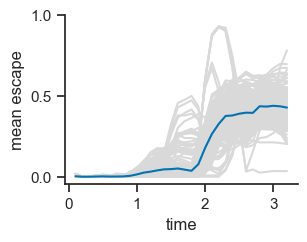

In [863]:
cluster = 7
data = clustered_window_data[
    clustered_window_data['sorted_cluster'] == cluster
].copy()
print(len(data['antibody'].unique()))
data = data.sample(frac=1, random_state=2)

antibodies = list(data[
    #(data['time'].between(2.2, 2.3)) &
    #(data['escape_score'] < 0.5) &
    (data['escape_score'] > 0)
]['antibody'].unique())#[:5]
#antibodies = ['XGv-343', 'XGv-198', 'XGv-212', 'XGv-251']
#print(antibodies)

# Plot predictions
plt.figure(figsize=[3,2.2])
sns.lineplot(
    x='time', y='escape_score',
    data=data[data['antibody'].isin(antibodies)],
    units='antibody', estimator=None, c='0.85',
    #hue='antibody', hue_order=antibodies
)
sns.lineplot(
    x='time', y='escape_score',
    data=data[data['antibody'].isin(antibodies)],
    estimator='mean', errorbar=None
)
plt.yticks([0, 0.5, 1])
plt.ylabel('mean escape')
sns.despine()
plt.show()

Plot the distribution of IC50 values for a given set of antibodies from a given study.

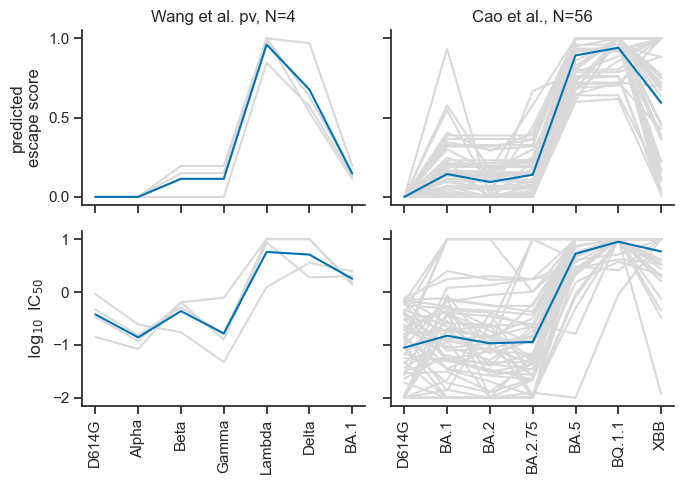

In [831]:
# Plotting params
virus_order = [
    'D614G',
    'Alpha', 'Beta', 'Gamma',
    'Lambda', 'Delta', 
    'Omicron',
    'BA.1', 'BA.2', 'BA.2.75',
    'BA.5', 'BQ.1.1',
    'XBB', 'XBB.1.5'
]
studies = [
    'Wang et al. pv',
    #'Wang et al. av',
    'Cao et al.',
]

(fig, axs) = plt.subplots(
    ncols=2, nrows=2, figsize=[7,5], sharex='col', sharey='row',
    gridspec_kw={'width_ratios': [1, 1]}
)
axs = axs.reshape(-1)

for (ax_i, study) in enumerate(studies):
    
    # Get IC50 data
    data = ic50s_df[
        (ic50s_df['antibody'].isin(antibodies)) &
        (ic50s_df['virus'].isin(virus_order)) &
        (ic50s_df['study'] == study)
    ].copy()
    data['log_IC50'].clip(lower=-2, inplace=True)

    # Sort the viruses for the x-axis
    virus_index_dict = {
        virus : i
        for (i, virus) in enumerate(virus_order)
    }
    data['order'] = data['virus'].apply(lambda x: virus_index_dict[x])
    data.sort_values('order', inplace=True)
    hue_order = sorted(data['antibody'].unique())
    
    # Select antibodies with a logIC50 below zero for D614G
    pivoted_data = data.pivot(
        index='antibody', columns='virus', values='log_IC50'
    )
    antibodies_to_plot = set(pivoted_data[
        (pivoted_data['D614G'] <= 0)
    ].index.values)
    
    # Select which antibodies to plot
    pivoted_data = data.pivot(
        index='antibody', columns='virus', values='escape_score' # 'log_IC50'
    )
    if 'Cao' in study:
        antibodies_to_plot = set.intersection(antibodies_to_plot, set(pivoted_data[
            #(pivoted_data['BA.1'] > 0.5) &
            #((pivoted_data['BA.1'] - pivoted_data['D614G']) > 0.5) &
            #((pivoted_data['BA.1'] - pivoted_data['BA.2']) > 0.5) &
            #((pivoted_data['BA.1'] - pivoted_data['BA.2']) < -0.5) &
            (pivoted_data['D614G'] <= 0)
        ].index.values))
    data = data[data['antibody'].isin(antibodies_to_plot)]

    # Plot data
    IC50_metric = 'log_IC50' #'escape_score' #  'IC50' # 
    for metric in ['escape_score', IC50_metric]:
        if metric == 'escape_score':
            n_abs = len(data['antibody'].unique())
            axs[ax_i].set(
                title=f'{study}, N={n_abs}',
                yticks=[0, 0.5, 1], ylabel='predicted\nescape score'
            )
            metric_ax_i = ax_i
        else:
            axs[ax_i+2].set(
                ylabel='$\log_{10}$ IC$_{50}$'
            )
            metric_ax_i = ax_i + 2
        sns.lineplot(
            x='virus', y=metric, data=data, ax=axs[metric_ax_i],
            units='antibody', estimator=None, c='0.85',
            #hue='antibody', hue_order=hue_order,
        )
        if True:
            sns.lineplot(
                x='virus', y=metric, data=data, ax=axs[metric_ax_i],
                estimator='mean', errorbar=None
            )

    for tick in axs[ax_i+2].get_xticklabels():
        tick.set_rotation(90)

axs[1].set(ylabel='')
axs[2].set(xlabel='')
axs[3].set(xlabel='', ylabel='')
#axs[0].get_legend().remove()
#axs[1].get_legend().remove()

#plt.suptitle(f'cluster {cluster}')
plt.tight_layout()
sns.despine()
plt.show()

Show trajectories for subset of antibodies from indicated study

56


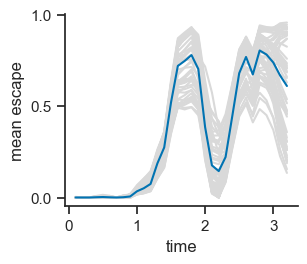

In [832]:
study = 'Cao et al.' # 'Wang et al. pv' # 
ic50_antibodies = ic50s_df[
    ic50s_df['study'] == study
]['antibody'].unique()
#antibodies_to_plot = list(set.intersection(set(antibodies), set(ic50_antibodies)))
data = clustered_window_data[
    #(clustered_window_data['sorted_cluster'] == cluster) &
    (clustered_window_data['antibody'].isin(antibodies_to_plot))
].copy()
print(len(data['antibody'].unique()))

# Plot predictions
plt.figure(figsize=[3,2.5])
sns.lineplot(
    x='time', y='escape_score', data=data,
    units='antibody', estimator=None, c='0.85',
)
sns.lineplot(
    x='time', y='escape_score', data=data,
    estimator='mean', errorbar=None
)
plt.yticks([0, 0.5, 1])
plt.ylabel('mean escape')
sns.despine()
plt.show()

Plot the correlation of escape score vs. IC50 values the subset of antibodies from each study

Wang et al. pv 0.82 0.0
Cao et al. 0.62 0.0


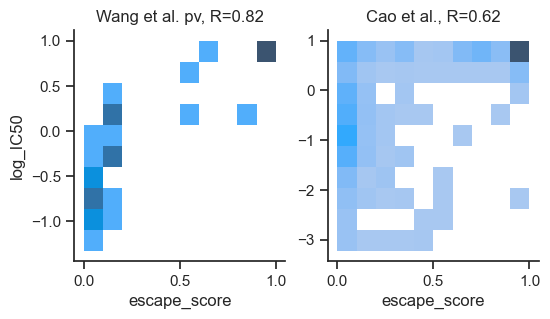

In [833]:
(fig, axs) = plt.subplots(
    ncols=2, figsize=[6,3],
    sharex=True, sharey=False
)
studies = ['Wang et al. pv', 'Cao et al.']
for (i, study) in enumerate(studies):
    data = ic50s_df[
        (ic50s_df['antibody'].isin(antibodies)) &
        #(ic50s_df['virus'].isin(['BA.2'])) &
        (ic50s_df['study'] == study)
    ].copy()
    (r, p) = scipy.stats.pearsonr(data['escape_score'], data['log_IC50'])
    print(study, round(r, 2), round(p, 2))

    sns.histplot(
        x='escape_score', y='log_IC50', data=data,
        bins=(10, 10), ax=axs[i]
    )
    axs[i].set(title=f'{study}, R={round(r, 2)}')

axs[1].set(ylabel='')
sns.despine()
plt.show()

Plot the distribution of R across antibodies from a given study

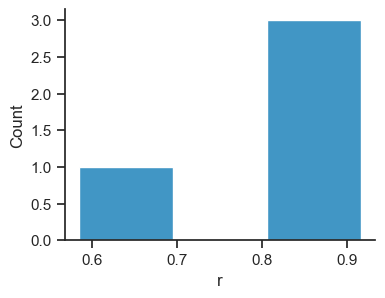

In [834]:
study = 'Wang et al. pv' # 'Cao et al.' # 
rs_dict = defaultdict(list)
for antibody in antibodies:
    data = ic50s_df[
        (ic50s_df['antibody'] == antibody) &
        (ic50s_df['study'] == study)
    ].copy()
    if len(data) < 1:
        continue
    (r, p) = scipy.stats.pearsonr(data['escape_score'], data['log_IC50'])
    rs_dict['antibody'].append(antibody)
    rs_dict['r'].append(r)

rs_df = pd.DataFrame(rs_dict)
plt.figure(figsize=[4,3])
sns.histplot(x='r', data=rs_df)
sns.despine()
plt.show()

In [835]:
rs_df.sort_values('r', ascending=False)

,antibody,r
1,XGv-198,0.916248
3,XGv-251,0.903102
0,XGv-343,0.831216
2,XGv-212,0.584610


In [771]:
ic50s_df[
    (ic50s_df['study'].isin(['Wang et al. pv'])) &
    (ic50s_df['antibody'] == 'XGv-155')
]

,antibody,virus,IC50,study,log_IC50,source,escape_score
19337,XGv-155,D614G,0.025513,Wang et al. pv,-1.593240,WT vaccinees,0.0000
19338,XGv-155,Alpha,0.012695,Wang et al. pv,-1.896352,WT vaccinees,0.0000
19339,XGv-155,Beta,6.256780,Wang et al. pv,0.796351,WT vaccinees,1.0000
19340,XGv-155,Gamma,10.000000,Wang et al. pv,1.000000,WT vaccinees,1.0000
19341,XGv-155,Delta,0.014066,Wang et al. pv,-1.851839,WT vaccinees,0.0000
19342,XGv-155,Lambda,0.025609,Wang et al. pv,-1.591605,WT vaccinees,0.2855
19343,XGv-155,BA.1,10.000000,Wang et al. pv,1.000000,WT vaccinees,1.0000


In [787]:
site_escape_df[
    site_escape_df['antibody'] == 'XGv-152' # 'XGv-198' # 'XGv-010' # 'BD55-1962' # 'BD55-1035'
].sort_values('site')

,antibody,site,escape
108087,XGv-152,347,0.05779
108088,XGv-152,352,0.05218
108089,XGv-152,427,0.03551
108090,XGv-152,446,0.03279
108091,XGv-152,448,0.04500
108092,XGv-152,452,0.06028
108093,XGv-152,456,0.08732
108094,XGv-152,468,0.03652
108095,XGv-152,471,0.03200
108096,XGv-152,472,0.16110


In [887]:
import logomaker
import dmslogo

/Users/haddox/miniconda3/envs/ncov-ab-escape/lib/python3.9/site-packages/dmslogo/logo.py:46: RuntimeWarning: Cannot load font /System/Library/Fonts/LastResort.otf
  warnings.warn(f"Cannot load font {_fontfile}", RuntimeWarning)


In [781]:
aa_mut_df = pd.read_csv('data/ncov_escape_scores/use_res_clean.csv')

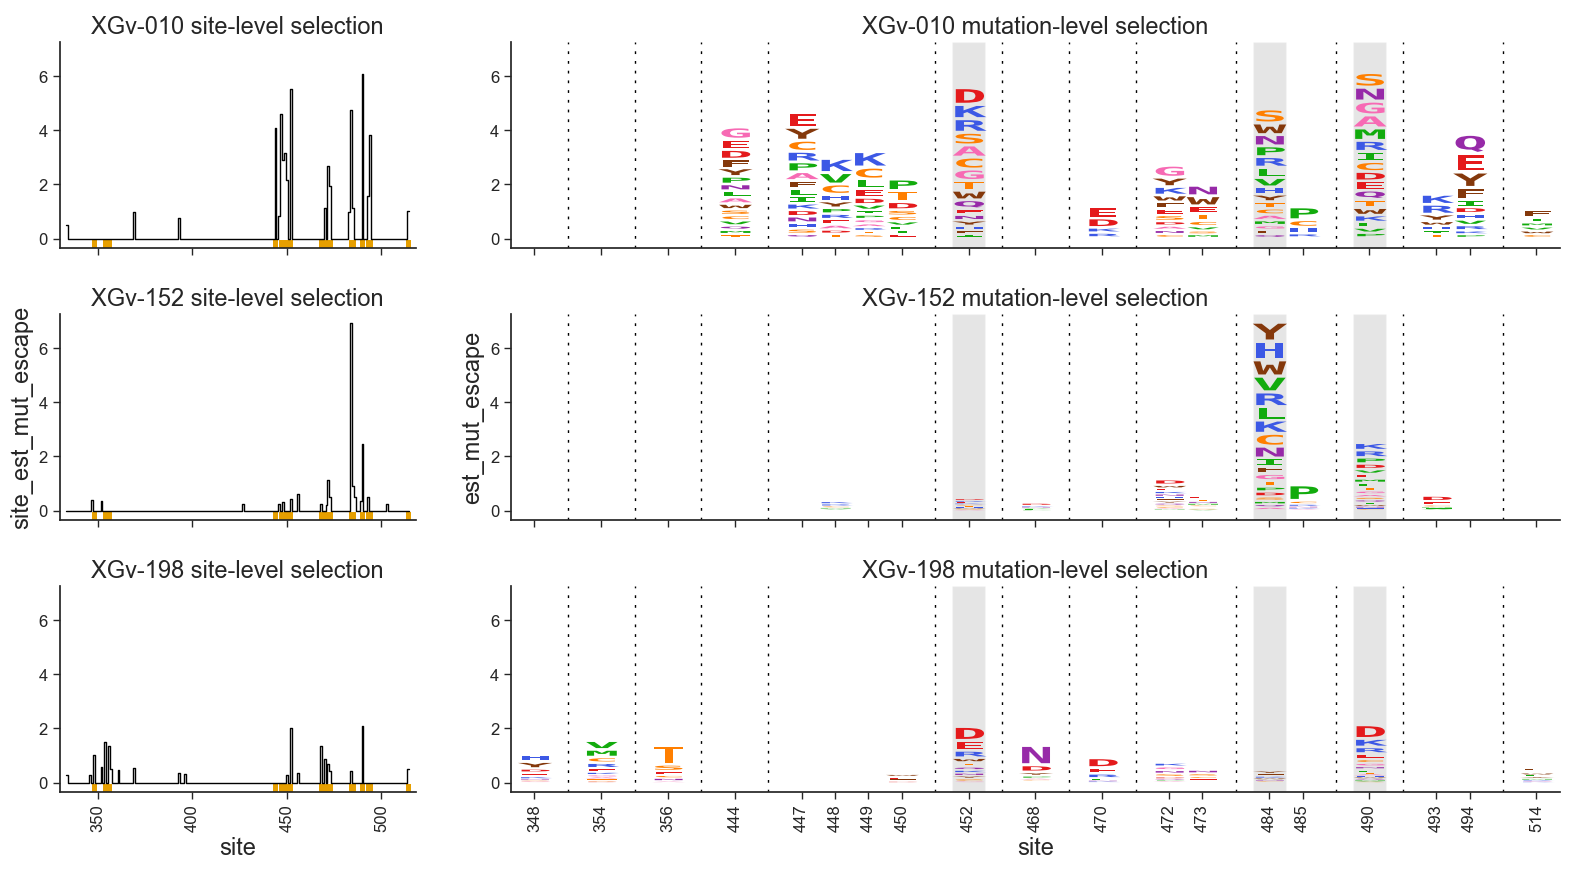

In [942]:
antibodies = [
    'XGv-152',
    'XGv-010',
    'XGv-198', #'XGv-251', 'BD55-1962'
]
data = aa_mut_df[
    aa_mut_df['antibody'].isin(antibodies)
].copy()

# Fill missing data with zeros
min_site = data['site'].min()
max_site = data['site'].max()
aas = list(data['mutation'].unique())

init_dict = defaultdict(list)
for antibody in antibodies:
    for site in range(min_site, max_site+1):
        for mutation in aas:
            init_dict['antibody'].append(antibody)
            init_dict['site'].append(site)
            init_dict['mutation'].append(mutation)
            init_dict['zeros'].append(0)
init_data = pd.DataFrame(init_dict)
data = data.merge(
    init_data, on=['antibody', 'site', 'mutation'], how='outer'
)
data['mut_escape'].fillna(0, inplace=True)
data['est_mut_escape'] = data['mut_escape'] + data['zeros']

# Add a column that gives the total escape at a site
site_data = data.groupby(['antibody', 'site']).agg('sum', numeric_only=True).reset_index()
site_data.rename(columns={'est_mut_escape': 'site_est_mut_escape'}, inplace=True)
data = data.merge(
    site_data[['antibody', 'site', 'site_est_mut_escape']],
    on=['antibody', 'site']
)
sites_to_show = data[data['site_est_mut_escape'] > 1]['site'].unique()
data['show_site'] = data['site'].isin(sites_to_show)

# Add a column giving sites to shade
sites_to_shade = [452, 484, 490]
data['shade_color'] = data['site'].apply(
    lambda x: 'grey' if x in sites_to_shade else None
)
data['shade_alpha'] = 0.2

# Plot data
(fig, axes) = dmslogo.facet_plot(
    data,
    gridrow_col='antibody',
    x_col='site',
    show_col='show_site',
    draw_line_kwargs=dict(
        height_col='site_est_mut_escape',
        #xtick_col='site'
    ),
    draw_logo_kwargs=dict(
        letter_col='mutation',
        letter_height_col='est_mut_escape',
        #xtick_col='site_label',
        xlabel='site',
        shade_color_col='shade_color',
        shade_alpha_col='shade_alpha'
    ),
    line_titlesuffix='site-level selection',
    logo_titlesuffix='mutation-level selection'
)

**Observations**:

* antibodies we could highlight
    * cluster 1:
        * LY-CoV016/XGv-225: strong escape at 417, weak or very weak at 484
        * XGv-152: strong escape at 484, weak at 490, very low at 452
    * cluster 2:
        * XGv-010: strong escape at 452, 484, and 490
    * cluster 3: 
        * XGv-198: strong escape at 452 and 490; weak escape at 484 and a handful of other sites

* sorted cluster 3
    * XGv-343, XGv-251: goes up with Delta, down with early Omicron, stays up with later omicron
    * BD56-1658:
    * Wang pv: in general, there tends to be a large increase in IC50 between pre-Delta/Lambda and Delta/Lambda, then a decrease between Delta and Omicron.
    * Wang av: same as above, but lacking Omicron data
    * Cao et al.

* bumps that check out
    * BD-824
* maybe
    * BD55-1962
* no
    * 1-57

Analyze trends for individual antibodies in a given cluster

In [864]:
cluster = 7
data = clustered_window_data[
    clustered_window_data['sorted_cluster'] == cluster
].copy()
print(len(data['antibody'].unique()))
#data = data.sample(frac=1, random_state=2)

antibodies = list(data['antibody'].unique())#[:5]
antibodies[:4]

175


['BD-255', 'BD-713', 'BD-904', 'BD-915']

BD55-1004


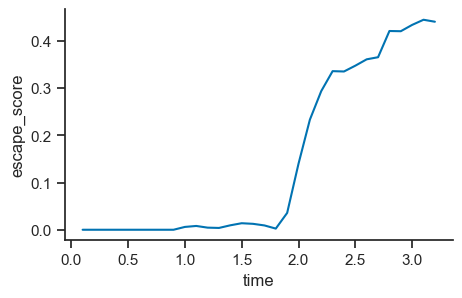

In [868]:
antibody = antibodies[4] #'LY-CoV016' # 'XGv-198' # 'XGv-152' # 'XGv-097' # 'XGv-010' # , 'XGv-172', 'XGv-271' # 'BD-824' # 'B38' # '2-15' # 'BD55-939'# 'BD56-1892' # '1-57' # 'BD55-1962' # 'BD55-1035' # 'BD55-1066' # antibodies[3] # 'BD-623' # '1-57' #
print(antibody)
ab_window_data = window_data[window_data['antibody'] == antibody].copy()
plt.figure(figsize=[5,3])
sns.lineplot(x='time', y='escape_score', data=ab_window_data)
sns.despine()
plt.show()

In [869]:
escape_df[
    (escape_df['time'].between(2, 2.9)) &
    #(escape_df['Nextstrain_clade'].str.contains('Delta')) &
    (escape_df['escape_score'] > 0.2) &
    (escape_df['antibody'] == antibody)
].sort_values('escape_score', ascending=False).head()

,strain,aa_substitutions,escape_score,antibody,ab_group,date,Nextstrain_clade,time
4907396,VNM/NHTD-OUCRU3772/2022,R346T K356T S371F T376A,0.6003,BD55-1004,F1,2022-10-28,22D (Omicron),2.841096
6038042,KEN/SS11113/2022,R346T K356T S371F T376A,0.6003,BD55-1004,F1,2022-11-12,22D (Omicron),2.882192
2910014,VNM/NHTD-OUCRU3771/2022,R346T K356T S371F T376A,0.6003,BD55-1004,F1,2022-10-31,22D (Omicron),2.849315
1679360,VNM/NHTD-OUCRU3762/2022,R346T K356T S371F T376A,0.6003,BD55-1004,F1,2022-10-24,22D (Omicron),2.830137
5437994,BHR/440009472/2022,R346T K356T S371F T376A,0.6003,BD55-1004,F1,2022-10-31,22D (Omicron),2.849315


For all sites with DMS data that escape the antibody, compute the correlation between the mutation's trajectory and the escape trajectory.

In [870]:
# Get a list of mutations to analyze
mut_sites = list(site_escape_df[
    #(site_escape_df['escape'] > 0.9) &
    (site_escape_df['antibody'] == antibody)
]['site'])

# Compute the frequency of each mutation over time
mut_freq_dict = defaultdict(list)
dfs = []
for left_side_of_window in list_of_left_sides_of_windows:
    right_side_of_window = left_side_of_window + window_width
    center_of_window = (left_side_of_window + right_side_of_window) / 2
    
    # Get data for viruses within a given window
    data = escape_df[
        (escape_df['antibody'] == antibody) &
        (escape_df['time'].between(left_side_of_window, right_side_of_window))
    ].copy()
    data['aa_substitutions'].fillna('', inplace=True)
    
    # Record the frequency of each mutation
    for mut_site in mut_sites:
        mut_freq_dict['time'].append(center_of_window)
        mut_freq_dict['mut_site'].append(mut_site)
        mut_freq_dict['mut_freq'].append(
            sum(data['aa_substitutions'].str.contains(f'\w{mut_site}\w')) / len(data)
        )

mut_freq_df = pd.DataFrame(mut_freq_dict)
mut_freq_df['mut_freq'].fillna(0, inplace=True)

In [871]:
# Compute the frequency of each mutation in each clade
clade_mut_freq_dict = defaultdict(list)
dfs = []
for clade in sorted(list(escape_df['Nextstrain_clade'].unique())):
    
    # Get data for viruses within a given clade
    data = escape_df[
        (escape_df['antibody'] == antibody) &
        (escape_df['Nextstrain_clade'] == clade)
    ].copy()
    data['aa_substitutions'].fillna('', inplace=True)
    
    # Record the frequency of each mutation
    for mut_site in mut_sites:
        clade_mut_freq_dict['clade'].append(clade)
        clade_mut_freq_dict['mut_site'].append(mut_site)
        clade_mut_freq_dict['mut_freq'].append(
            sum(data['aa_substitutions'].str.contains(f'\w{mut_site}\w')) / len(data)
        )

clade_mut_freq_df = pd.DataFrame(clade_mut_freq_dict)
clade_mut_freq_df['mut_freq'].fillna(0, inplace=True)

In [872]:
data = ab_window_data.merge(mut_freq_df, on='time')
data['abs_error'] = abs(data['escape_score'] - data['mut_freq'])
corr_dict = defaultdict(list)
for mut_site in mut_sites:
    data_i = data[data['mut_site'] == mut_site]
    mae = round(data_i['abs_error'].mean(), 2)
    r = round(data_i['escape_score'].corr(data_i['mut_freq']), 2)
    corr_dict['site'].append(mut_site)
    corr_dict['max_freq'].append(round(data_i['mut_freq'].max(), 2))
    corr_dict['mae'].append(mae)
    corr_dict['r'].append(r)
    
corr_df = pd.DataFrame(corr_dict)

ab_site_escape_df = site_escape_df[
    (site_escape_df['antibody'] == antibody)
].copy()

corr_df = corr_df.merge(ab_site_escape_df, on='site', how='left')
corr_df['r'].fillna(0, inplace=True)
#corr_df.sort_values('r', ascending=False, inplace=True)
corr_df.sort_values('escape', ascending=False, inplace=True)
corr_df.head(n=12)

,site,max_freq,mae,r,antibody,escape
12,383,0.00,0.15,0.00,BD55-1004,1.0000
13,384,0.00,0.15,0.00,BD55-1004,0.4709
15,386,0.00,0.15,0.00,BD55-1004,0.2899
5,365,0.00,0.15,0.00,BD55-1004,0.2736
14,385,0.00,0.15,0.00,BD55-1004,0.2668
9,374,0.00,0.15,0.00,BD55-1004,0.2263
7,371,0.97,0.22,0.98,BD55-1004,0.1993
22,525,0.00,0.15,0.00,BD55-1004,0.1866
1,347,0.00,0.15,0.39,BD55-1004,0.1842
18,462,0.00,0.15,0.00,BD55-1004,0.1802


Plot data

BD55-1004


KeyError: 'BD55-1004'

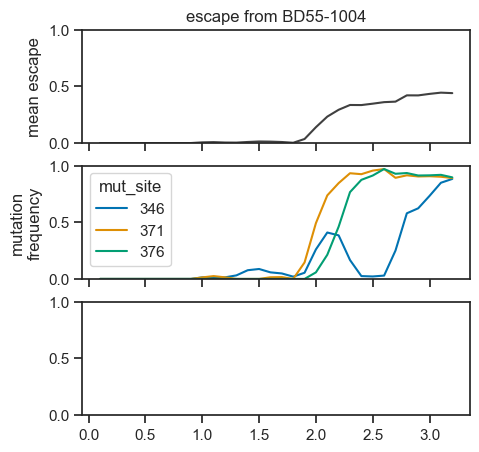

In [874]:
# Plot data
print(antibody)
(fig, axs) = plt.subplots(
    nrows=3, sharex=True, sharey=True,
    figsize=[5,5]
)

# Plot changes in escape score over time
data = window_data[window_data['antibody'] == antibody].copy()
sns.lineplot(
    x='time', y='escape_score', data=data, ax=axs[0], c='0.25'
)
axs[0].set(
    ylabel=f'mean escape', ylim=[0,1],
    title=f'escape from {antibody}'
)

# Plot changes in mutation frequency
sites_to_plot = corr_df[
    #(corr_df['mae'] < 0.4) &
    (corr_df['r'] > 0.2) &
    (corr_df['max_freq'] > 0.1) &
    (corr_df['escape'] > 0.1) # 0.1
]['site']
sites_to_plot = list(map(str, sites_to_plot))
data = mut_freq_df.copy()
data['mut_site'] = data['mut_site'].astype(str)
data = data[data['mut_site'].isin(sites_to_plot)]
sns.lineplot(
    x='time', y='mut_freq', data=data, hue='mut_site', ax=axs[1],
    #hue_order=['484', '490', '452']
)
axs[1].set(ylabel='mutation\nfrequency')

# Plot clade frequency
clade_plotting_params = {
    'B38' : [
        ('VOC\npre-Delta', ['Alpha', 'Beta', 'Gamma', 'Kappa', 'Eta', 'Theta', 'Mu'], 1.30, 0.23, 'k'),
        ('Omicron', ['Omicron'], 2.6, 0.55, 'w'),
        ('Delta', ['Delta'], 1.75, 0.65, 'k'),
    ],
    'LY-CoV016' : [
        ('VOC\npre-Delta', ['Alpha', 'Beta', 'Gamma', 'Kappa', 'Eta', 'Theta', 'Mu'], 1.30, 0.23, 'k'),
        ('Omicron', ['Omicron'], 2.6, 0.55, 'w'),
        ('Delta', ['Delta'], 1.75, 0.65, 'k'),
    ],
    '2-15' : [
        ('VOC\npre-Delta', ['Alpha', 'Beta', 'Gamma', 'Kappa', 'Eta', 'Theta', 'Mu'], 1.30, 0.23, 'k'),
        ('Omicron', ['Omicron'], 2.6, 0.55, 'w'),
        ('Delta', ['Delta'], 1.75, 0.65, 'k'),
    ],
    
    'BD55-1962' : [
        ('Delta', ['Delta'], 1.75, 0.35, 'k'),
        ('Omicron\npost-21L', ['22A', '22B', '22C', '22D', '22E', '22F', '23A', '23B'], 2.75, 0.375, 'w'),
        ('Omicron\n21K/L', ['21K', '21L'], 2.2, 0.65, 'k'),
    ],
    '1-57' : [
        ('21K', ['21K'], 2.1, 0.25, 'k'),
        ('22D/F\n23A/B', ['22D', '22F', '23A', '23B'], 3.0, 0.15, 'w'),
        ('21L-\n22C/E', ['21L', '22A', '22B', '22C', '22E'], 2.6, 0.65, 'k'),
    ],
    'BD-824' : [
        ('21K', ['21K'], 2.1, 0.25, 'k'),
        ('22F\n23A/B', ['22F', '23A', '23B'], 3.0, 0.15, 'w'),
        ('21L-\n22E', ['21L', '22A', '22B', '22C', '22D', '22E'], 2.6, 0.65, 'k'),
    ],
    
    'BD-623' : [
        ('', [''], 2.1, 0.25, 'k'),
        ('22A/B/E/F,\n23A/B', ['22A', '22B', '22E', '22F', '23A', '23B'], 2.85, 0.5, 'w'),
        ('', [''], 2.6, 0.65, 'k'),
    ],
    'BD55-1035' : [
        ('VOC\npre-Delta', ['Alpha', 'Beta', 'Gamma', 'Kappa', 'Eta', 'Theta', 'Mu'], 1.30, 0.23, 'k'),
        ('Omicron', ['Omicron'], 2.6, 0.55, 'w'),
        ('Delta', ['Delta'], 1.75, 0.65, 'k'),
    ],
    'BD-449' : [
        ('', [''], 2.1, 0.25, 'k'),
        ('Omicron', ['Omicron'], 2.6, 0.5, 'w'),
        ('', [''], 2.6, 0.65, 'k'),
    ],
    'BD-498' : [
        ('21K', ['21K'], 2.1, 0.25, 'k'),
        ('22D/F,\n23A/B', ['22D', '22F', '23A', '23B'], 3.1, 0.15, 'k'),
        ('21L,\n22A/B/C/E', ['21L', '22A', '22B', '22C', '22E'], 2.6, 0.65, 'k'),
    ],
    'BD55-1066' : [
        ('VOC\npre-Delta', ['Alpha', 'Beta', 'Gamma', 'Kappa', 'Eta', 'Theta', 'Mu'], 1.30, 0.23, 'k'),
        ('Omicron', ['Omicron'], 2.6, 0.55, 'w'),
        ('Delta', ['Delta'], 1.75, 0.65, 'k'),
    ],
}

clade_freqs_df.sort_values('time', inplace=True)
dfs = []
for params in clade_plotting_params[antibody]:
    (group_name, clade_strs, text_x, text_y, text_c) = params
    data = clade_freqs_df[
        clade_freqs_df['clade'].str.contains('|'.join(clade_strs))
    ].copy()
    data = data.groupby('time').sum(numeric_only=True)
    data['clade'] = group_name
    if group_name == '':
        data['freq'] = 0
    dfs.append(data)
    axs[2].text(
        text_x, text_y, group_name, c=text_c,
        ha='center', va='center'
    )

axs[2].stackplot(
    dfs[0].index, dfs[0]['freq'], dfs[1]['freq'], dfs[2]['freq'],
    #labels=['VOCs pre-Delta', 'Omicron', 'Delta'],
    colors=['lightpink', 'firebrick', '0.85'],
    baseline='zero', #zorder=0
)
axs[2].set(xlabel='time', ylabel='clade\nfrequency')
#axs[1].get_legend(bbox_to_anchor=(1,1))
for i in range(3):
    axs[i].grid()

sns.despine()
plt.show()

**Observations**
* cluster 1
    * 417 and 484: increase with pre-Delta VOCs, decreases with Delta, then increase again with Omicrons. See examples where 417 mainly drives escape (B38) and where 484 mainly drives escape (2-15)
* cluster 2
    * 452 and 484 (among others that increase in freq later): 484 increases with pre-Delta VOCs, then is replaced by 452, then gets replaced by 484. So, at least for some antibodies in the cluster, escape always stays high but different mutations contribute (e.g., BD55-1035).
    * 478: increases in Delta and stays high (e.g., BD55-1066)
* cluster 3
    * 452 and 490: 452 increases with Delta, goes down with early Omicron variants, then increases with later variants, and is now decreasing again. 490 increases in later variants as 452 has decreased.
* cluster 6
    * 375: mutations at this site increase with Omicron

In [236]:
escape_df[escape_df['antibody'] == 'BD55-1962']

,strain,aa_substitutions,escape_score,antibody,ab_group,date,Nextstrain_clade,time
739,ON641975.1,E484A,0.1891,BD55-1962,D1,2022-01-08,?,2.038356
3517,FRA/IHUCOVID-046100_Nova1/2021,NaN,0.0000,BD55-1962,D1,2021-02-02,20A,1.106849
6295,ON395492.1,E484A,0.1891,BD55-1962,D1,2022-04-14,?,2.301370
9073,FRA/2205V210014/2022,E484A,0.1891,BD55-1962,D1,2022-05-21,21L (Omicron),2.402740
11851,Japan/SZ-NIG-Y223306/2023,R346T L452R E484A,1.0000,BD55-1962,D1,2023-02-07,22B (Omicron),3.120548
...,...,...,...,...,...,...,...,...
8270845,IMS-10375-CVDP-9D6D1D43-7EAC-4FF4-86C4-DC49E7B...,R346T E484A F490S,1.0000,BD55-1962,D1,2023-03-07,23A (Omicron),3.197260
8273623,IMS-10375-CVDP-36A500BC-1CB5-4F04-87E7-AE2937D...,R346T E484A F490S,1.0000,BD55-1962,D1,2023-04-05,22F (Omicron),3.276712
8276401,IMS-10375-CVDP-7186DB5B-78DE-47E6-AF5F-5905CA1...,R346T E484A F490S,1.0000,BD55-1962,D1,2023-04-06,23A (Omicron),3.279452
8279179,IMS-10375-CVDP-42AE8A93-7024-4DBF-8837-18BCF12...,R346T E484A F490S,1.0000,BD55-1962,D1,2023-04-10,23A (Omicron),3.290411


Plot the frequency of a mutation among clades

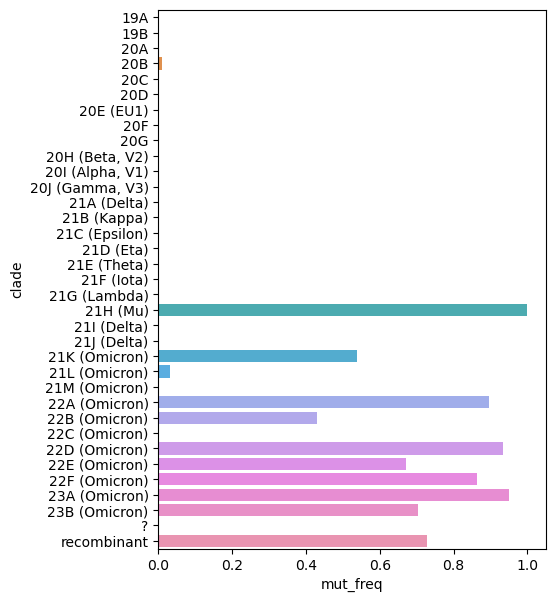

In [222]:
data = clade_mut_freq_df[
    clade_mut_freq_df['mut_site'] == 346
]
plt.figure(figsize=[5,7])
sns.barplot(x='mut_freq', y='clade', data=data)
plt.show()

In [238]:
escape_df[
    (escape_df['Nextstrain_clade'].str.contains('Omicron')) &
    (escape_df['antibody'] == antibody) &
    (escape_df['time'] < 0.5)
]

,strain,aa_substitutions,escape_score,antibody,ab_group,date,Nextstrain_clade,time
42171,PER/1117/2020,NaN,0.0,BD-824,D1,2020-01-12,21K (Omicron),0.046575
5214807,PER/5616/2020,NaN,0.0,BD-824,D1,2020-02-21,21K (Omicron),0.156164
5909307,USA/OKPHL0022663/2020,NaN,0.0,BD-824,D1,2020-01-27,21K (Omicron),0.087671


Observations
* B38 from group A
    * alpha has the N501Y escape mutation (escape score of 0.27)
    * beta and gamma have the K417N, E484K, and N501Y escape mutations
    * delta lacks  these mutations
    * omicron has the K417N, E484A, N501Y escape mutations
    * the above mutations spike and dip at the same time as the average-escape plot
* 2-15 from group C
    * same as above, but for the 484 mutation?

* BD-623 from group B
    * escape at 486

* 1-57 from group D1
    * escape patterns track with mutations at 446 (G446S?)
    * BA.1 has this mutation, BA.2 does not, but then it occurs later on in omicron evolution    
* BD55-1962 from group D1
    * escape at 452
    
* BD55-1036 from group D2
    * escape at 445
* BD55-1104 from group D2
    * escape at 444, 445, 446
    
* BD55-1245 from group E1
    * escape at 371, 373
    
* BD-713 from group E2.1
    * escape at 346, 452, 484
    * accumulation of multiple partial-escape mutations
* BD-744 from group E2.1
    * escape at 346, 452
    * interesting tradeoff between mutations
* BD55-1312 from group E2.1
    * escape at 484, 490
    * accumulation of multiple partial-escape mutations
* BD-901 from group E2.1
    * escape at 346, 376, 490
    * accumulation of multiple partial-escape mutations
    
* ADG-2 from group F3
    * escape at 408 with partial escape at 484, 505
* BD55-5259 from group F3
    * partial escape at 375, 505
* BD55-5448 from group F3
    * partial escape at many sites: 405, 408, 484, 496, 501, 505

## Validate predictions

In [944]:
# Make a list of input files, with one file per antibody
ab_escape_files = glob.glob('data/ncov_escape_scores/*escape_prediction.csv')

# Read in data from each file and store data in a dataframe
antibodies = []
for (i, f) in enumerate(ab_escape_files):
    df = pd.read_csv(f)
    ab = os.path.basename(f).replace('_polclonal_escape_prediction.csv', '').replace('_escape_score_variant_escape_prediction.csv', '')
    if 'additive' in df.columns.values:
        escape_score_col = f'{ab}_escape_score'
        df.rename(columns={'additive' : escape_score_col}, inplace=True)
    else:
        escape_score_col = f'{ab}_IC90_log_fold_change'

    if i == 0:
        escape_df = df[['strain', 'aa_substitutions', escape_score_col]]
    else:
        escape_df = escape_df.merge(
            df[['strain', escape_score_col]],
            on='strain'
        )
    antibodies.append(escape_score_col)

# Add a column giving the date of each strain
metadata_df = pd.read_csv(
    'data/ncov_escape_scores/metadata_with_index.tsv',
    sep='\t', on_bad_lines='skip'
    )

escape_df = escape_df.merge(
    metadata_df[['strain', 'date', 'Nextstrain_clade']], on='strain'
)
escape_df['date'] = pd.to_datetime(escape_df['date'])
escape_df['time'] = (escape_df['date'] - escape_df['date'].min()).dt.days / 365
escape_df.head()

,strain,aa_substitutions,CC9.104_IC90_log_fold_change,NTD_5-7_IC90_log_fold_change,C68.61-BA2_escape_score,C68.3-BA2_escape_score,LCB1_v2.2_stringent-WH1_escape_score,C68.59_IC90_log_fold_change,LY-CoV1404-BA1_escape_score,C68.3-BA1_escape_score,CC67.105_IC90_log_fold_change,date,Nextstrain_clade,time
0,Wuhan-Hu-1/2019,V67A I95T I212L D339G L371S P373S F375S N417K ...,1.203864,-2.203219,0.103019,0.072882,0.0,1.010647,0.137017,0.11961,0.683449,2019-12-26,19A,0.000000
1,NPL/61-TW/2020,V67A I95T I212L D339G L371S P373S F375S N417K ...,1.203864,-2.203219,0.103019,0.072882,0.0,1.010647,0.137017,0.11961,0.683449,2020-01-13,19A,0.049315
2,Mesocricetusauratus/HKG/13_P2/2020,V67A I95T I212L D339G L371S P373S F375S N417K ...,1.203864,-2.203219,0.103019,0.072882,0.0,1.010647,0.137017,0.11961,0.683449,2020-05-15,19A,0.386301
3,CHN/Hefei-362/2020,V67A I95T I212L D339G L371S P373S F375S N417K ...,1.203864,-2.203219,0.103019,0.072882,0.0,1.010647,0.137017,0.11961,0.683449,2020-02-09,19A,0.123288
4,USA/WI-CDC-03041142-001/2020,V67A I95T I212L D339G L371S P373S F375S N417K ...,1.203864,-2.203219,0.103019,0.072882,0.0,1.010647,0.137017,0.11961,0.683449,2020-01-31,19A,0.098630


In [966]:
ly_cov1404_ic50s = [
    ('BA.2', 0.9),
    ('XBB', 10000),
    ('BA.2.75', 2.2),
    ('BA.5', 0.8),
    ('BQ.1.1', 1905),
]
ly_cov1404_dict = defaultdict(list)
for (strain, ic50) in ly_cov1404_ic50s:
    ly_cov1404_dict['strain'].append(strain)
    ly_cov1404_dict['virus'].append(strain_virus_dict[strain][0])
    ly_cov1404_dict['log_ic50'].append(np.log10(ic50))

ly_cov1404_ic50s_df = pd.DataFrame(ly_cov1404_dict)

In [967]:
ly_cov1404_escape = escape_df[['strain', 'LY-CoV1404-BA1_escape_score']].copy()
ly_cov1404_escape.rename(columns={
    'strain' : 'virus',
    'LY-CoV1404-BA1_escape_score' : 'escape_score'
}, inplace=True)
ly_cov1404_escape = ly_cov1404_escape.merge(ly_cov1404_ic50s_df, on='virus')

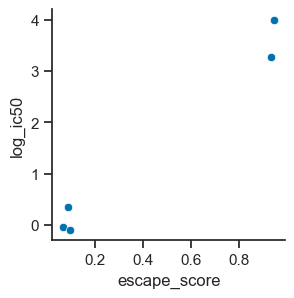

In [968]:
plt.figure(figsize=(3,3))
sns.scatterplot(x='escape_score', y='log_ic50', data=ly_cov1404_escape)
sns.despine()
plt.show()

<Figure size 300x300 with 0 Axes>

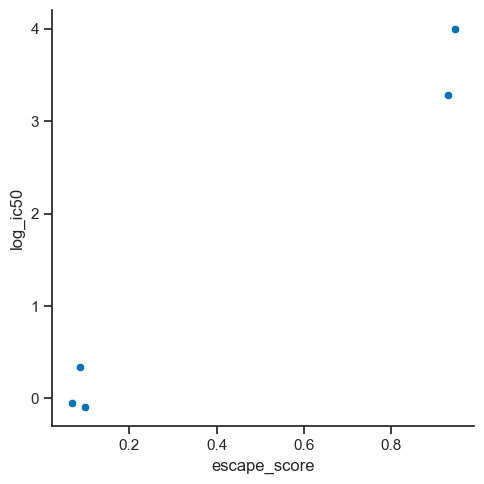

In [965]:
plt.figure(figsize=(3,3))
sns.relplot(x='escape_score', y='log_ic50', data=ly_cov1404_escape)
sns.despine()
plt.show()

In [884]:
strain_virus_dict['BA.2']

('AUS/QIMR02/2022',
 ['T19I',
  'L24-',
  'P25-',
  'P26-',
  'A27S',
  'G142D',
  'V213G',
  'G339D',
  'S371F',
  'S373P',
  'S375F',
  'T376A',
  'D405N',
  'R408S',
  'K417N',
  'N440K',
  'S477N',
  'T478K',
  'E484A',
  'Q493R',
  'Q498R',
  'N501Y',
  'Y505H',
  'D614G',
  'H655Y',
  'N679K',
  'P681H',
  'N764K',
  'D796Y',
  'Q954H',
  'N969K'])

In [881]:
ic50s_df[
    ic50s_df['antibody'].str.contains('LY')
]#['antibody'].unique()

,antibody,virus,IC50,study,log_IC50,source,escape_score
18325,LY-CoV016,BA.1,10.000000,Cao et al.,1.000000,WT convalescents,1.00000
18326,LY-CoV016,BA.2,10.000000,Cao et al.,1.000000,WT convalescents,1.00000
18327,LY-CoV016,BA.2.75,10.000000,Cao et al.,1.000000,WT convalescents,1.00000
18328,LY-CoV016,BA.5,10.000000,Cao et al.,1.000000,WT convalescents,1.00000
18329,LY-CoV016,BQ.1.1,10.000000,Cao et al.,1.000000,WT convalescents,1.00000
18330,LY-CoV016,D614G,0.032000,Cao et al.,-1.494850,WT convalescents,0.00000
18331,LY-CoV016,XBB,10.000000,Cao et al.,1.000000,WT convalescents,1.00000
18332,LY-CoV016,D614G,NaN,Wang et al. av,NaN,WT convalescents,0.00000
18333,LY-CoV016,Beta,NaN,Wang et al. av,NaN,WT convalescents,1.00000
18334,LY-CoV016,Gamma,NaN,Wang et al. av,NaN,WT convalescents,1.00000
